# CAPTCHA Recognition Pipeline with Segmentation

This notebook integrates the character segmentation approach from `segmentation.py` with a CNN-based character recognition model.

## 1. Environment Setup

In [29]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Character set
CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"
VOCAB_SIZE = len(CHARS)
ch2id = {ch: i for i, ch in enumerate(CHARS)}
id2ch = {i: ch for ch, i in ch2id.items()}

print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Characters: {CHARS}")

device: cpu
Vocabulary size: 36
Characters: 0123456789abcdefghijklmnopqrstuvwxyz


## 2. Import Segmentation Functions. Try hyper-parameter tuning with segment_characters method

Import the segmentation functions directly from `segmentation_v2.py`.

In [ ]:
# Import segmentation functions from segmentation.py
from segmentation_v2 import segment_characters

## 3. Character Dataset

Dataset class that segments CAPTCHAs and provides individual character images for training.

In [31]:
class SegmentedCharDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_size=(32, 32)):
        """
        Args:
            img_paths: List of CAPTCHA image paths
            transform: Optional transform to be applied on characters
            target_size: Target size for character images (H, W)
        """
        self.img_paths = img_paths
        self.transform = transform
        self.target_size = target_size
        
        # Pre-segment all images and build character dataset
        self.characters = []  # List of (char_image, label)
        self._build_dataset()
    
    def _build_dataset(self):
        print("Segmenting CAPTCHA images...")
        for img_path in tqdm(self.img_paths):
            try:
                gt_text = Path(img_path).stem.split('-')[0]
                char_images, _seg_labels = segment_characters(img_path)

                if len(char_images) == 0:
                    continue

                # Align using ground truth (trusted) and left-to-right order from segmentation
                n = min(len(char_images), len(gt_text))
                if n < len(gt_text) or n < len(char_images):
                    print(f"[INFO] Mismatch kept={len(char_images)} vs GT={len(gt_text)} for {Path(img_path).name}; using first {n} aligned pairs")

                for k in range(n):
                    ch = gt_text[k].lower()
                    if ch in ch2id:
                        self.characters.append((char_images[k], ch))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        print(f"Total characters extracted: {len(self.characters)}")
    
    def __len__(self):
        return len(self.characters)
    
    def __getitem__(self, idx):
        char_img, label = self.characters[idx]
        
        # Preprocess character image
        char_img = self._preprocess_char(char_img)
        
        # Convert to tensor
        char_img = torch.from_numpy(char_img).float() / 255.0
        
        # Ensure 3 channels
        if char_img.dim() == 2:
            char_img = char_img.unsqueeze(0).repeat(3, 1, 1)
        elif char_img.shape[0] == 1:
            char_img = char_img.repeat(3, 1, 1)

        if self.transform:
            char_img = self.transform(char_img)
                    
        label_id = ch2id[label]
        
        return char_img, label_id, label
    
    def _preprocess_char(self, char_img):
        """
        Preprocess a single character image:
        - Convert to grayscale
        - Resize to target size
        - Maintain aspect ratio with padding
        """
        # Convert to grayscale if needed
        if len(char_img.shape) == 3:
            char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
        
        h, w = char_img.shape
        target_h, target_w = self.target_size
        
        # Check for invalid dimensions
        if h <= 0 or w <= 0:
            # Return blank canvas if image is empty
            return np.ones((target_h, target_w), dtype=np.uint8) * 255
        
        # Calculate scaling to fit within target size
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Ensure minimum size of 1x1
        new_h = max(1, new_h)
        new_w = max(1, new_w)
        
        # Resize
        char_img = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        
        # Create white canvas and center the character
        canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
        y_offset = (target_h - new_h) // 2
        x_offset = (target_w - new_w) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
        
        return canvas

## 4. Load and Prepare Data

In [32]:
# Data directories
TRAIN_ROOT = "processed/train"
TEST_ROOT = "processed/test"

# Get image files
train_img_files = [
    os.path.join(TRAIN_ROOT, f)
    for f in os.listdir(TRAIN_ROOT)
    if f.lower().endswith(".png")
]

test_img_files = [
    os.path.join(TEST_ROOT, f)
    for f in os.listdir(TEST_ROOT)
    if f.lower().endswith(".png")
]

print(f"Train CAPTCHA images: {len(train_img_files)}")
print(f"Test CAPTCHA images: {len(test_img_files)}")

Train CAPTCHA images: 7820
Test CAPTCHA images: 2000


In [33]:
# Create datasets (use full data) and add augmentations
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL first
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))], p=0.2),
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# For eval: just normalize
test_transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

print("\nCreating training dataset (full set)...")
train_dataset = SegmentedCharDataset(train_img_files, transform=train_transform, target_size=(32, 32))

print("\nCreating test dataset (full set)...")
test_dataset = SegmentedCharDataset(test_img_files, transform=test_transform, target_size=(32, 32))


Creating training dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 0/7820 [00:00<?, ?it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


  0%|          | 5/7820 [00:00<07:46, 16.76it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  0%|          | 15/7820 [00:00<03:58, 32.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clu

  0%|          | 23/7820 [00:00<03:46, 34.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 27/7820 [00:00<03:48, 34.14it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  0%|          | 31/7820 [00:01<03:46, 34.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


  0%|          | 35/7820 [00:01<03:42, 34.91it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 43/7820 [00:01<04:06, 31.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|          | 51/7820 [00:01<04:03, 31.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 55/7820 [00:01<03:58, 32.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  1%|          | 60/7820 [00:01<03:34, 36.24it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 65/7820 [00:02<03:24, 37.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 73/7820 [00:02<03:41, 35.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 81/7820 [00:02<03:49, 33.68it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  1%|          | 86/7820 [00:02<03:36, 35.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 94/7820 [00:02<04:03, 31.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|▏         | 103/7820 [00:03<03:43, 34.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  1%|▏         | 111/7820 [00:03<03:36, 35.63it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 119/7820 [00:03<03:39, 35.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 128/7820 [00:03<03:27, 37.15it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 177).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 138/7820 [00:04<03:11, 40.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 130).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 92).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans c

  2%|▏         | 143/7820 [00:04<03:22, 37.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  2%|▏         | 151/7820 [00:04<03:38, 35.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  2%|▏         | 162/7820 [00:04<03:05, 41.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans cl

  2%|▏         | 167/7820 [00:04<03:17, 38.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 176/7820 [00:05<03:18, 38.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans cl

  2%|▏         | 185/7820 [00:05<03:11, 39.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans cl

  2%|▏         | 195/7820 [00:05<03:08, 40.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans cl

  3%|▎         | 200/7820 [00:05<03:01, 41.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 210/7820 [00:05<03:08, 40.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans cl

  3%|▎         | 220/7820 [00:06<03:14, 38.98it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  3%|▎         | 229/7820 [00:06<03:10, 39.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans cl

  3%|▎         | 237/7820 [00:06<03:29, 36.15it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  3%|▎         | 245/7820 [00:06<03:23, 37.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).


  3%|▎         | 249/7820 [00:06<03:26, 36.73it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  3%|▎         | 258/7820 [00:07<03:19, 37.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans cl

  3%|▎         | 267/7820 [00:07<03:20, 37.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 92).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


  4%|▎         | 276/7820 [00:07<03:15, 38.58it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 280/7820 [00:07<03:33, 35.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  4%|▎         | 290/7820 [00:08<03:10, 39.44it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans cl

  4%|▍         | 299/7820 [00:08<03:18, 37.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clu

  4%|▍         | 310/7820 [00:08<02:54, 43.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans cl

  4%|▍         | 320/7820 [00:08<03:03, 40.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  4%|▍         | 325/7820 [00:08<02:59, 41.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 121).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans c

  4%|▍         | 335/7820 [00:09<02:53, 43.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 88).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans cl

  4%|▍         | 345/7820 [00:09<03:08, 39.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clu

  5%|▍         | 355/7820 [00:09<03:03, 40.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).


  5%|▍         | 360/7820 [00:09<03:05, 40.13it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 91).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▍         | 370/7820 [00:10<03:12, 38.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 104).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans c

  5%|▍         | 380/7820 [00:10<03:04, 40.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  5%|▍         | 389/7820 [00:10<03:10, 39.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  5%|▌         | 393/7820 [00:10<03:15, 37.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  5%|▌         | 403/7820 [00:10<03:06, 39.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans cl

  5%|▌         | 412/7820 [00:11<03:15, 37.98it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 176).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  5%|▌         | 422/7820 [00:11<03:00, 40.95it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans cl

  5%|▌         | 427/7820 [00:11<03:12, 38.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans cl

  6%|▌         | 438/7820 [00:11<02:57, 41.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 448/7820 [00:12<03:02, 40.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).


  6%|▌         | 453/7820 [00:12<02:58, 41.17it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  6%|▌         | 463/7820 [00:12<03:09, 38.75it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).


  6%|▌         | 467/7820 [00:12<03:31, 34.70it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▌         | 477/7820 [00:12<03:09, 38.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans cl

  6%|▌         | 485/7820 [00:12<03:12, 38.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 489/7820 [00:13<03:25, 35.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 498/7820 [00:13<03:32, 34.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans cl

  6%|▋         | 508/7820 [00:13<03:05, 39.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans cl

  7%|▋         | 518/7820 [00:13<03:03, 39.83it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 523/7820 [00:14<03:12, 37.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  7%|▋         | 531/7820 [00:14<03:27, 35.13it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 540/7820 [00:14<03:15, 37.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 219).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans cl

  7%|▋         | 548/7820 [00:14<03:13, 37.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 557/7820 [00:14<03:15, 37.11it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 125).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  7%|▋         | 565/7820 [00:15<03:20, 36.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 574/7820 [00:15<03:05, 39.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans cl

  7%|▋         | 578/7820 [00:15<03:14, 37.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 586/7820 [00:15<03:24, 35.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 595/7820 [00:15<03:08, 38.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans cl

  8%|▊         | 603/7820 [00:16<03:11, 37.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 612/7820 [00:16<03:05, 38.80it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 101).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans c

  8%|▊         | 620/7820 [00:16<03:08, 38.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 100).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  8%|▊         | 629/7820 [00:16<02:57, 40.41it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 634/7820 [00:17<03:17, 36.41it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 104).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 642/7820 [00:17<03:28, 34.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 651/7820 [00:17<03:27, 34.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  8%|▊         | 656/7820 [00:17<03:17, 36.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 181).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


  9%|▊         | 665/7820 [00:17<03:10, 37.65it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  9%|▊         | 675/7820 [00:18<03:13, 37.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 685/7820 [00:18<03:05, 38.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 689/7820 [00:18<03:16, 36.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).


  9%|▉         | 699/7820 [00:18<03:02, 39.07it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  9%|▉         | 708/7820 [00:18<03:04, 38.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans cl

  9%|▉         | 713/7820 [00:19<03:01, 39.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 721/7820 [00:19<03:24, 34.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  9%|▉         | 730/7820 [00:19<03:02, 38.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clu

  9%|▉         | 740/7820 [00:19<02:59, 39.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 745/7820 [00:19<03:04, 38.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 753/7820 [00:20<03:18, 35.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|▉         | 762/7820 [00:20<03:09, 37.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|▉         | 771/7820 [00:20<03:08, 37.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 10%|▉         | 779/7820 [00:20<03:16, 35.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 92).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 10%|█         | 788/7820 [00:21<03:06, 37.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 10%|█         | 793/7820 [00:21<03:00, 38.99it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 803/7820 [00:21<03:05, 37.73it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans cl

 10%|█         | 807/7820 [00:21<03:10, 36.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 10%|█         | 816/7820 [00:21<03:01, 38.61it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans cl

 11%|█         | 824/7820 [00:22<03:14, 36.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 131).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 833/7820 [00:22<03:08, 37.16it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans cl

 11%|█         | 842/7820 [00:22<02:59, 38.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans cl

 11%|█         | 850/7820 [00:22<03:20, 34.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 100).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█         | 854/7820 [00:22<03:43, 31.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 141).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 11%|█         | 863/7820 [00:23<03:14, 35.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 154).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans cl

 11%|█         | 874/7820 [00:23<02:56, 39.26it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 11%|█▏        | 884/7820 [00:23<02:54, 39.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 139).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans c

 11%|█▏        | 889/7820 [00:23<03:11, 36.17it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 11%|█▏        | 897/7820 [00:24<03:26, 33.51it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 111).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 905/7820 [00:24<03:22, 34.12it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 916/7820 [00:24<02:42, 42.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans cl

 12%|█▏        | 926/7820 [00:24<02:44, 41.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans cl

 12%|█▏        | 931/7820 [00:24<02:57, 38.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 116).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 12%|█▏        | 940/7820 [00:25<02:46, 41.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clu

 12%|█▏        | 951/7820 [00:25<02:42, 42.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans cl

 12%|█▏        | 961/7820 [00:25<02:49, 40.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 966/7820 [00:25<02:45, 41.33it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 976/7820 [00:26<02:52, 39.67it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 981/7820 [00:26<02:57, 38.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 990/7820 [00:26<03:01, 37.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 999/7820 [00:26<02:56, 38.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 1004/7820 [00:26<02:50, 40.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1013/7820 [00:27<03:08, 36.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans cl

 13%|█▎        | 1022/7820 [00:27<03:16, 34.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1030/7820 [00:27<03:22, 33.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1038/7820 [00:27<03:20, 33.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 13%|█▎        | 1043/7820 [00:27<03:15, 34.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 13%|█▎        | 1052/7820 [00:28<03:14, 34.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 86).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 14%|█▎        | 1060/7820 [00:28<03:08, 35.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 14%|█▎        | 1068/7820 [00:28<03:23, 33.17it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 92).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▎        | 1072/7820 [00:28<03:26, 32.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1081/7820 [00:29<03:04, 36.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1089/7820 [00:29<03:04, 36.55it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1098/7820 [00:29<03:02, 36.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans cl

 14%|█▍        | 1106/7820 [00:29<03:10, 35.33it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 101).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1115/7820 [00:29<03:02, 36.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 14%|█▍        | 1119/7820 [00:30<03:02, 36.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 1128/7820 [00:30<02:57, 37.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans cl

 15%|█▍        | 1139/7820 [00:30<02:43, 40.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clu

 15%|█▍        | 1149/7820 [00:30<02:36, 42.61it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▍        | 1154/7820 [00:31<03:05, 35.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 94).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 15%|█▍        | 1164/7820 [00:31<02:55, 38.02it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans cl

 15%|█▌        | 1174/7820 [00:31<02:38, 41.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clu

 15%|█▌        | 1184/7820 [00:31<02:41, 41.04it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1189/7820 [00:31<02:47, 39.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 15%|█▌        | 1198/7820 [00:32<02:57, 37.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 1207/7820 [00:32<02:58, 37.03it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans cl

 16%|█▌        | 1216/7820 [00:32<02:53, 38.07it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1225/7820 [00:32<02:46, 39.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 112).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans c

 16%|█▌        | 1230/7820 [00:32<02:47, 39.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▌        | 1239/7820 [00:33<02:55, 37.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 16%|█▌        | 1248/7820 [00:33<03:02, 36.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1252/7820 [00:33<03:09, 34.63it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 1260/7820 [00:33<03:04, 35.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans cl

 16%|█▌        | 1269/7820 [00:34<02:48, 38.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clu

 16%|█▋        | 1280/7820 [00:34<02:45, 39.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 16%|█▋        | 1289/7820 [00:34<02:53, 37.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1294/7820 [00:34<02:50, 38.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1303/7820 [00:34<02:59, 36.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 93).
[INFO] Detected 6 characters — using 7 KMeans cl

 17%|█▋        | 1308/7820 [00:35<02:58, 36.49it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 1317/7820 [00:35<02:53, 37.51it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans cl

 17%|█▋        | 1326/7820 [00:35<02:50, 38.02it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 17%|█▋        | 1334/7820 [00:35<03:01, 35.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 17%|█▋        | 1339/7820 [00:35<02:56, 36.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 17%|█▋        | 1348/7820 [00:36<03:01, 35.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clu

 17%|█▋        | 1357/7820 [00:36<02:51, 37.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clus

 17%|█▋        | 1366/7820 [00:36<02:48, 38.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1375/7820 [00:36<02:37, 40.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans cl

 18%|█▊        | 1385/7820 [00:37<02:53, 37.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1389/7820 [00:37<03:25, 31.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 18%|█▊        | 1397/7820 [00:37<03:06, 34.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 198).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1405/7820 [00:37<03:08, 34.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 18%|█▊        | 1413/7820 [00:37<03:03, 34.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1422/7820 [00:38<02:46, 38.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans cl

 18%|█▊        | 1432/7820 [00:38<02:46, 38.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 99).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 1441/7820 [00:38<02:46, 38.41it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clu

 19%|█▊        | 1451/7820 [00:38<02:36, 40.67it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 95).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans cl

 19%|█▊        | 1456/7820 [00:39<02:55, 36.29it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▊        | 1465/7820 [00:39<02:49, 37.40it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 139).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1475/7820 [00:39<02:36, 40.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 19%|█▉        | 1480/7820 [00:39<02:49, 37.48it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 19%|█▉        | 1488/7820 [00:39<03:03, 34.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 19%|█▉        | 1497/7820 [00:40<02:43, 38.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 96).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clu

 19%|█▉        | 1507/7820 [00:40<02:41, 39.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans cl

 19%|█▉        | 1517/7820 [00:40<02:40, 39.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clu

 19%|█▉        | 1521/7820 [00:40<02:46, 37.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 1530/7820 [00:41<02:41, 38.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans cl

 20%|█▉        | 1540/7820 [00:41<02:38, 39.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clu

 20%|█▉        | 1550/7820 [00:41<02:31, 41.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans cl

 20%|█▉        | 1560/7820 [00:41<02:32, 41.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans cl

 20%|██        | 1566/7820 [00:41<02:22, 43.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans cl

 20%|██        | 1576/7820 [00:42<02:32, 40.98it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans cl

 20%|██        | 1586/7820 [00:42<02:24, 43.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 167).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 20%|██        | 1591/7820 [00:42<02:44, 37.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 20%|██        | 1599/7820 [00:42<02:50, 36.44it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans cl

 21%|██        | 1608/7820 [00:42<02:43, 37.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1617/7820 [00:43<02:53, 35.68it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 105).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1625/7820 [00:43<02:46, 37.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans cl

 21%|██        | 1635/7820 [00:43<02:39, 38.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 21%|██        | 1643/7820 [00:43<02:45, 37.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██        | 1651/7820 [00:44<02:46, 37.08it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 1659/7820 [00:44<02:48, 36.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██▏       | 1667/7820 [00:44<02:55, 35.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 21%|██▏       | 1675/7820 [00:44<02:56, 34.87it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1683/7820 [00:45<02:49, 36.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 133).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 22%|██▏       | 1688/7820 [00:45<02:40, 38.18it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1696/7820 [00:45<03:02, 33.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 22%|██▏       | 1704/7820 [00:45<02:50, 35.86it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 86).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clu

 22%|██▏       | 1712/7820 [00:45<02:48, 36.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 22%|██▏       | 1721/7820 [00:46<02:38, 38.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans cl

 22%|██▏       | 1731/7820 [00:46<02:29, 40.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 304).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans c

 22%|██▏       | 1736/7820 [00:46<02:26, 41.54it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 1745/7820 [00:46<02:36, 38.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans cl

 22%|██▏       | 1755/7820 [00:46<02:41, 37.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1764/7820 [00:47<02:33, 39.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 90).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans cl

 23%|██▎       | 1776/7820 [00:47<02:09, 46.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans cl

 23%|██▎       | 1781/7820 [00:47<02:20, 42.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 23%|██▎       | 1791/7820 [00:47<02:27, 40.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 23%|██▎       | 1802/7820 [00:48<02:15, 44.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans cl

 23%|██▎       | 1807/7820 [00:48<02:24, 41.74it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 1817/7820 [00:48<02:40, 37.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 23%|██▎       | 1821/7820 [00:48<02:45, 36.18it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).


 23%|██▎       | 1829/7820 [00:48<02:59, 33.46it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 24%|██▎       | 1838/7820 [00:49<02:40, 37.16it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans cl

 24%|██▎       | 1847/7820 [00:49<02:41, 37.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 137).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▎       | 1855/7820 [00:49<02:40, 37.28it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 1860/7820 [00:49<02:34, 38.61it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 24%|██▍       | 1868/7820 [00:49<02:59, 33.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 1877/7820 [00:50<02:56, 33.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 147).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 134).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 24%|██▍       | 1882/7820 [00:50<02:42, 36.49it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans cl

 24%|██▍       | 1892/7820 [00:50<02:25, 40.64it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 24%|██▍       | 1902/7820 [00:50<02:24, 40.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans cl

 24%|██▍       | 1907/7820 [00:50<02:24, 40.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1918/7820 [00:51<02:17, 42.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans cl

 25%|██▍       | 1928/7820 [00:51<02:21, 41.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans c

 25%|██▍       | 1938/7820 [00:51<02:26, 40.18it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans cl

 25%|██▍       | 1947/7820 [00:51<02:32, 38.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 106).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▍       | 1952/7820 [00:51<02:29, 39.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1960/7820 [00:52<02:45, 35.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 1969/7820 [00:52<02:40, 36.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans cl

 25%|██▌       | 1978/7820 [00:52<02:31, 38.58it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1982/7820 [00:52<02:39, 36.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 112).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 25%|██▌       | 1991/7820 [00:53<02:49, 34.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 1999/7820 [00:53<02:53, 33.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▌       | 2004/7820 [00:53<02:42, 35.85it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clu

 26%|██▌       | 2014/7820 [00:53<02:21, 40.93it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 26%|██▌       | 2024/7820 [00:53<02:19, 41.56it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans cl

 26%|██▌       | 2034/7820 [00:54<02:16, 42.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans cl

 26%|██▌       | 2044/7820 [00:54<02:13, 43.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 99).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans c

 26%|██▋       | 2054/7820 [00:54<02:13, 43.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans cl

 26%|██▋       | 2059/7820 [00:54<02:21, 40.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 26%|██▋       | 2069/7820 [00:54<02:23, 40.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans cl

 27%|██▋       | 2079/7820 [00:55<02:21, 40.49it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans cl

 27%|██▋       | 2084/7820 [00:55<02:18, 41.41it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 27%|██▋       | 2094/7820 [00:55<02:19, 41.07it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).


 27%|██▋       | 2104/7820 [00:55<02:27, 38.65it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 27%|██▋       | 2109/7820 [00:56<02:25, 39.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clus

 27%|██▋       | 2119/7820 [00:56<02:15, 42.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans cl

 27%|██▋       | 2129/7820 [00:56<02:20, 40.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans cl

 27%|██▋       | 2139/7820 [00:56<02:29, 37.99it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


 27%|██▋       | 2144/7820 [00:56<02:22, 39.77it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2154/7820 [00:57<02:25, 38.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans cl

 28%|██▊       | 2159/7820 [00:57<02:24, 39.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2168/7820 [00:57<02:35, 36.34it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2176/7820 [00:57<02:36, 36.04it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).


 28%|██▊       | 2184/7820 [00:57<02:37, 35.85it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2193/7820 [00:58<02:40, 35.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2201/7820 [00:58<02:38, 35.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 28%|██▊       | 2206/7820 [00:58<02:35, 36.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 28%|██▊       | 2214/7820 [00:58<02:36, 35.83it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 28%|██▊       | 2223/7820 [00:59<02:30, 37.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▊       | 2231/7820 [00:59<02:37, 35.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 29%|██▊       | 2241/7820 [00:59<02:25, 38.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 29%|██▉       | 2249/7820 [00:59<02:28, 37.48it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 94).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 29%|██▉       | 2258/7820 [00:59<02:27, 37.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 114).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans c

 29%|██▉       | 2263/7820 [01:00<02:17, 40.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clu

 29%|██▉       | 2274/7820 [01:00<02:02, 45.19it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clu

 29%|██▉       | 2285/7820 [01:00<01:58, 46.79it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clu

 29%|██▉       | 2295/7820 [01:00<02:15, 40.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 2305/7820 [01:01<02:06, 43.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans cl

 30%|██▉       | 2310/7820 [01:01<02:17, 40.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clu

 30%|██▉       | 2320/7820 [01:01<02:11, 41.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|██▉       | 2329/7820 [01:01<02:25, 37.78it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2334/7820 [01:01<02:17, 39.77it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|██▉       | 2345/7820 [01:02<02:17, 39.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 30%|███       | 2355/7820 [01:02<02:05, 43.56it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans cl

 30%|███       | 2365/7820 [01:02<02:13, 40.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans cl

 30%|███       | 2370/7820 [01:02<02:15, 40.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 30%|███       | 2379/7820 [01:02<02:24, 37.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2388/7820 [01:03<02:20, 38.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clu

 31%|███       | 2393/7820 [01:03<02:26, 36.92it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 2402/7820 [01:03<02:18, 39.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans cl

 31%|███       | 2412/7820 [01:03<02:03, 43.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans cl

 31%|███       | 2423/7820 [01:04<02:12, 40.60it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 147).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 2433/7820 [01:04<02:10, 41.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans cl

 31%|███       | 2438/7820 [01:04<02:11, 40.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 31%|███▏      | 2447/7820 [01:04<02:20, 38.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 31%|███▏      | 2457/7820 [01:04<02:10, 41.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans cl

 32%|███▏      | 2468/7820 [01:05<02:07, 41.90it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 103).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 126).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans 

 32%|███▏      | 2474/7820 [01:05<02:05, 42.70it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans cl

 32%|███▏      | 2485/7820 [01:05<02:00, 44.43it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans cl

 32%|███▏      | 2495/7820 [01:05<02:09, 41.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 98).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans cl

 32%|███▏      | 2505/7820 [01:06<02:11, 40.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 115).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 32%|███▏      | 2511/7820 [01:06<02:01, 43.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans cl

 32%|███▏      | 2521/7820 [01:06<02:05, 42.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 2531/7820 [01:06<02:16, 38.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 120).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 32%|███▏      | 2536/7820 [01:06<02:15, 39.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2544/7820 [01:07<02:29, 35.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2552/7820 [01:07<02:29, 35.31it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2561/7820 [01:07<02:17, 38.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2569/7820 [01:07<02:19, 37.58it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2577/7820 [01:07<02:22, 36.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans cl

 33%|███▎      | 2586/7820 [01:08<02:17, 38.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2595/7820 [01:08<02:18, 37.82it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 33%|███▎      | 2603/7820 [01:08<02:29, 34.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 33%|███▎      | 2611/7820 [01:08<02:24, 36.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 33%|███▎      | 2615/7820 [01:08<02:27, 35.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▎      | 2626/7820 [01:09<02:11, 39.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans cl

 34%|███▎      | 2636/7820 [01:09<02:03, 42.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans cl

 34%|███▍      | 2647/7820 [01:09<01:58, 43.55it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans cl

 34%|███▍      | 2657/7820 [01:09<01:59, 43.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans cl

 34%|███▍      | 2662/7820 [01:10<01:58, 43.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 196).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans c

 34%|███▍      | 2672/7820 [01:10<02:01, 42.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans cl

 34%|███▍      | 2682/7820 [01:10<02:11, 39.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 180).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▍      | 2692/7820 [01:10<02:02, 41.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans cl

 34%|███▍      | 2697/7820 [01:10<02:09, 39.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2706/7820 [01:11<02:19, 36.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans cl

 35%|███▍      | 2717/7820 [01:11<02:02, 41.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 2722/7820 [01:11<02:07, 40.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 35%|███▍      | 2731/7820 [01:11<02:17, 36.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans cl

 35%|███▌      | 2739/7820 [01:12<02:21, 36.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 131).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 93).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 35%|███▌      | 2750/7820 [01:12<02:06, 40.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans cl

 35%|███▌      | 2755/7820 [01:12<02:00, 41.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 91).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans cl

 35%|███▌      | 2765/7820 [01:12<01:54, 44.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans cl

 35%|███▌      | 2775/7820 [01:12<02:08, 39.13it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 36%|███▌      | 2786/7820 [01:13<01:58, 42.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans cl

 36%|███▌      | 2791/7820 [01:13<02:02, 40.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 162).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans c

 36%|███▌      | 2801/7820 [01:13<01:54, 43.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clu

 36%|███▌      | 2811/7820 [01:13<02:05, 40.06it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 110).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 2820/7820 [01:13<02:14, 37.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans cl

 36%|███▌      | 2830/7820 [01:14<02:04, 40.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans cl

 36%|███▋      | 2835/7820 [01:14<02:00, 41.33it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans cl

 36%|███▋      | 2845/7820 [01:14<02:02, 40.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 138).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans c

 37%|███▋      | 2855/7820 [01:14<02:00, 41.23it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 106).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans c

 37%|███▋      | 2865/7820 [01:15<02:05, 39.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2875/7820 [01:15<01:55, 42.83it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clu

 37%|███▋      | 2885/7820 [01:15<01:51, 44.10it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans cl

 37%|███▋      | 2890/7820 [01:15<02:05, 39.24it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 37%|███▋      | 2900/7820 [01:15<02:04, 39.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 99).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans cl

 37%|███▋      | 2905/7820 [01:16<02:02, 40.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 37%|███▋      | 2915/7820 [01:16<02:05, 39.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans cl

 37%|███▋      | 2925/7820 [01:16<02:00, 40.70it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans cl

 38%|███▊      | 2935/7820 [01:16<02:00, 40.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans cl

 38%|███▊      | 2940/7820 [01:16<02:06, 38.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 38%|███▊      | 2950/7820 [01:17<02:02, 39.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans cl

 38%|███▊      | 2960/7820 [01:17<01:58, 40.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2965/7820 [01:17<01:57, 41.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 2975/7820 [01:17<01:59, 40.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 6 characters — using 7 KMeans cl

 38%|███▊      | 2985/7820 [01:18<02:02, 39.55it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 38%|███▊      | 2990/7820 [01:18<02:02, 39.52it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3000/7820 [01:18<02:05, 38.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 3009/7820 [01:18<02:02, 39.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans cl

 39%|███▊      | 3018/7820 [01:18<01:59, 40.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans cl

 39%|███▊      | 3029/7820 [01:19<01:50, 43.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans cl

 39%|███▉      | 3034/7820 [01:19<01:51, 43.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans cl

 39%|███▉      | 3044/7820 [01:19<02:08, 37.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3053/7820 [01:19<02:03, 38.75it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 108).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans c

 39%|███▉      | 3063/7820 [01:20<01:54, 41.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 104).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans c

 39%|███▉      | 3068/7820 [01:20<01:57, 40.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 119).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 39%|███▉      | 3077/7820 [01:20<02:11, 36.04it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 39%|███▉      | 3085/7820 [01:20<02:07, 37.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 40%|███▉      | 3095/7820 [01:20<01:51, 42.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clu

 40%|███▉      | 3100/7820 [01:21<02:03, 38.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|███▉      | 3110/7820 [01:21<01:54, 41.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clu

 40%|███▉      | 3120/7820 [01:21<02:07, 36.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|███▉      | 3124/7820 [01:21<02:05, 37.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 104).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 40%|████      | 3134/7820 [01:21<02:02, 38.27it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 167).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans c

 40%|████      | 3145/7820 [01:22<01:47, 43.48it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans cl

 40%|████      | 3156/7820 [01:22<01:41, 45.83it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans cl

 40%|████      | 3166/7820 [01:22<01:48, 43.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 41%|████      | 3171/7820 [01:22<01:49, 42.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████      | 3181/7820 [01:23<01:59, 38.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans cl

 41%|████      | 3191/7820 [01:23<01:52, 41.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans cl

 41%|████      | 3200/7820 [01:23<02:01, 37.90it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 41%|████      | 3204/7820 [01:23<02:10, 35.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 3213/7820 [01:23<02:05, 36.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans cl

 41%|████      | 3223/7820 [01:24<01:53, 40.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans cl

 41%|████▏     | 3234/7820 [01:24<01:45, 43.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans cl

 41%|████▏     | 3239/7820 [01:24<01:46, 43.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).


 42%|████▏     | 3249/7820 [01:24<01:59, 38.16it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3258/7820 [01:24<02:00, 37.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 3263/7820 [01:25<01:55, 39.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans cl

 42%|████▏     | 3273/7820 [01:25<01:55, 39.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 42%|████▏     | 3283/7820 [01:25<01:54, 39.57it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans cl

 42%|████▏     | 3294/7820 [01:25<01:43, 43.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans cl

 42%|████▏     | 3299/7820 [01:25<01:54, 39.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 119).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 3310/7820 [01:26<01:47, 41.93it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans cl

 42%|████▏     | 3320/7820 [01:26<01:46, 42.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans cl

 43%|████▎     | 3325/7820 [01:26<01:54, 39.31it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 43%|████▎     | 3335/7820 [01:26<01:48, 41.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans cl

 43%|████▎     | 3346/7820 [01:27<01:40, 44.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clu

 43%|████▎     | 3351/7820 [01:27<01:41, 44.02it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 43%|████▎     | 3361/7820 [01:27<01:48, 41.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans cl

 43%|████▎     | 3372/7820 [01:27<01:49, 40.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 43%|████▎     | 3383/7820 [01:27<01:42, 43.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clu

 43%|████▎     | 3393/7820 [01:28<01:38, 44.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clu

 44%|████▎     | 3403/7820 [01:28<01:37, 45.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 135).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans c

 44%|████▎     | 3409/7820 [01:28<01:32, 47.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans cl

 44%|████▎     | 3419/7820 [01:28<02:00, 36.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


 44%|████▍     | 3423/7820 [01:28<02:06, 34.87it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3431/7820 [01:29<02:10, 33.70it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 44%|████▍     | 3439/7820 [01:29<02:18, 31.67it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 98).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 44%|████▍     | 3443/7820 [01:29<02:12, 33.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 44%|████▍     | 3451/7820 [01:29<02:14, 32.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 3459/7820 [01:30<02:07, 34.30it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans cl

 44%|████▍     | 3469/7820 [01:30<01:48, 40.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans cl

 44%|████▍     | 3479/7820 [01:30<01:42, 42.21it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans cl

 45%|████▍     | 3484/7820 [01:30<01:47, 40.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 45%|████▍     | 3493/7820 [01:30<01:54, 37.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans cl

 45%|████▍     | 3503/7820 [01:31<01:48, 39.73it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 118).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 139).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▍     | 3513/7820 [01:31<01:44, 41.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans cl

 45%|████▌     | 3523/7820 [01:31<01:40, 42.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clu

 45%|████▌     | 3528/7820 [01:31<02:05, 34.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 45%|████▌     | 3537/7820 [01:32<01:57, 36.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clu

 45%|████▌     | 3549/7820 [01:32<01:39, 42.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans cl

 45%|████▌     | 3554/7820 [01:32<01:46, 40.18it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans cl

 46%|████▌     | 3563/7820 [01:32<01:56, 36.67it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 3573/7820 [01:32<01:48, 39.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans cl

 46%|████▌     | 3583/7820 [01:33<01:42, 41.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans cl

 46%|████▌     | 3588/7820 [01:33<01:46, 39.85it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▌     | 3598/7820 [01:33<01:45, 40.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 153).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans c

 46%|████▌     | 3609/7820 [01:33<01:48, 38.98it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 306).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 46%|████▋     | 3619/7820 [01:34<01:38, 42.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans cl

 46%|████▋     | 3625/7820 [01:34<01:30, 46.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans cl

 46%|████▋     | 3635/7820 [01:34<01:30, 46.25it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans cl

 47%|████▋     | 3645/7820 [01:34<01:34, 43.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans cl

 47%|████▋     | 3655/7820 [01:34<01:41, 41.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 47%|████▋     | 3665/7820 [01:35<01:37, 42.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 103).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans cl

 47%|████▋     | 3675/7820 [01:35<01:38, 41.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans cl

 47%|████▋     | 3680/7820 [01:35<01:44, 39.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3690/7820 [01:35<01:44, 39.34it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 47%|████▋     | 3700/7820 [01:36<01:43, 39.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 108).
[INFO] Detected 4 characters — using 5 KMeans c

 47%|████▋     | 3705/7820 [01:36<01:43, 39.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 47%|████▋     | 3714/7820 [01:36<01:40, 40.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans cl

 48%|████▊     | 3724/7820 [01:36<01:44, 39.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 3733/7820 [01:36<01:48, 37.73it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans cl

 48%|████▊     | 3738/7820 [01:36<01:42, 39.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3747/7820 [01:37<01:49, 37.16it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans cl

 48%|████▊     | 3757/7820 [01:37<01:52, 36.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 48%|████▊     | 3761/7820 [01:37<01:58, 34.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 48%|████▊     | 3771/7820 [01:37<01:44, 38.76it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans cl

 48%|████▊     | 3781/7820 [01:38<01:38, 40.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans cl

 48%|████▊     | 3791/7820 [01:38<01:35, 42.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans cl

 49%|████▊     | 3796/7820 [01:38<01:36, 41.89it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 97).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▊     | 3806/7820 [01:38<01:43, 38.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans cl

 49%|████▉     | 3816/7820 [01:38<01:32, 43.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans cl

 49%|████▉     | 3826/7820 [01:39<01:36, 41.32it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans cl

 49%|████▉     | 3836/7820 [01:39<01:38, 40.58it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 49%|████▉     | 3841/7820 [01:39<01:38, 40.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans cl

 49%|████▉     | 3851/7820 [01:39<01:36, 41.19it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 112).
[INFO] Detected 4 characters — using 5 KMeans cl

 49%|████▉     | 3861/7820 [01:40<01:37, 40.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans cl

 50%|████▉     | 3871/7820 [01:40<01:37, 40.42it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 50%|████▉     | 3881/7820 [01:40<01:34, 41.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 108).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans c

 50%|████▉     | 3891/7820 [01:40<01:36, 40.69it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans cl

 50%|████▉     | 3896/7820 [01:40<01:36, 40.50it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|████▉     | 3905/7820 [01:41<01:43, 37.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans cl

 50%|█████     | 3916/7820 [01:41<01:33, 41.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans cl

 50%|█████     | 3921/7820 [01:41<01:32, 42.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 50%|█████     | 3931/7820 [01:41<01:44, 37.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans cl

 50%|█████     | 3940/7820 [01:42<01:38, 39.25it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans cl

 50%|█████     | 3945/7820 [01:42<01:40, 38.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans cl

 51%|█████     | 3956/7820 [01:42<01:27, 44.09it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans cl

 51%|█████     | 3966/7820 [01:42<01:36, 39.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3976/7820 [01:42<01:39, 38.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 51%|█████     | 3981/7820 [01:43<01:36, 39.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████     | 3990/7820 [01:43<01:39, 38.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clu

 51%|█████     | 4000/7820 [01:43<01:39, 38.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 91).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████▏    | 4010/7820 [01:43<01:31, 41.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans cl

 51%|█████▏    | 4020/7820 [01:44<01:29, 42.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans cl

 51%|█████▏    | 4025/7820 [01:44<01:28, 42.86it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans cl

 52%|█████▏    | 4035/7820 [01:44<01:26, 43.85it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 123).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4040/7820 [01:44<01:42, 37.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 52%|█████▏    | 4050/7820 [01:44<01:37, 38.79it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4059/7820 [01:45<01:32, 40.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans cl

 52%|█████▏    | 4069/7820 [01:45<01:28, 42.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans cl

 52%|█████▏    | 4074/7820 [01:45<01:29, 41.86it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 52%|█████▏    | 4084/7820 [01:45<01:35, 39.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 199).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans c

 52%|█████▏    | 4094/7820 [01:45<01:33, 39.82it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 52%|█████▏    | 4099/7820 [01:46<01:35, 39.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans cl

 53%|█████▎    | 4109/7820 [01:46<01:30, 40.83it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans cl

 53%|█████▎    | 4120/7820 [01:46<01:23, 44.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 106).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans c

 53%|█████▎    | 4131/7820 [01:46<01:23, 43.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans cl

 53%|█████▎    | 4141/7820 [01:46<01:20, 45.45it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans cl

 53%|█████▎    | 4146/7820 [01:47<01:25, 42.93it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4155/7820 [01:47<01:43, 35.41it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4163/7820 [01:47<01:46, 34.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 53%|█████▎    | 4168/7820 [01:47<01:38, 36.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans cl

 53%|█████▎    | 4178/7820 [01:47<01:30, 40.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans cl

 54%|█████▎    | 4187/7820 [01:48<01:37, 37.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 165).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans c

 54%|█████▎    | 4198/7820 [01:48<01:28, 40.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans cl

 54%|█████▎    | 4203/7820 [01:48<01:31, 39.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 54%|█████▍    | 4213/7820 [01:48<01:28, 40.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans cl

 54%|█████▍    | 4223/7820 [01:49<01:24, 42.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans cl

 54%|█████▍    | 4233/7820 [01:49<01:28, 40.68it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 54%|█████▍    | 4238/7820 [01:49<01:29, 40.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 54%|█████▍    | 4248/7820 [01:49<01:26, 41.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans cl

 54%|█████▍    | 4259/7820 [01:49<01:18, 45.37it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans cl

 55%|█████▍    | 4264/7820 [01:50<01:22, 43.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▍    | 4273/7820 [01:50<01:39, 35.58it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▍    | 4283/7820 [01:50<01:32, 38.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 55%|█████▍    | 4294/7820 [01:50<01:21, 43.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clu

 55%|█████▍    | 4299/7820 [01:50<01:19, 44.40it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 4309/7820 [01:51<01:33, 37.43it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 243).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 113).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▌    | 4317/7820 [01:51<01:32, 37.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 164).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 55%|█████▌    | 4326/7820 [01:51<01:28, 39.33it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 55%|█████▌    | 4334/7820 [01:51<01:35, 36.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 55%|█████▌    | 4340/7820 [01:52<01:24, 41.23it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans cl

 56%|█████▌    | 4350/7820 [01:52<01:29, 38.86it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans cl

 56%|█████▌    | 4361/7820 [01:52<01:17, 44.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans cl

 56%|█████▌    | 4371/7820 [01:52<01:23, 41.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4376/7820 [01:52<01:22, 41.62it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans cl

 56%|█████▌    | 4386/7820 [01:53<01:22, 41.79it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 56%|█████▌    | 4396/7820 [01:53<01:30, 38.01it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 56%|█████▋    | 4401/7820 [01:53<01:27, 39.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 56%|█████▋    | 4409/7820 [01:53<01:30, 37.85it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans cl

 57%|█████▋    | 4420/7820 [01:53<01:16, 44.20it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans cl

 57%|█████▋    | 4430/7820 [01:54<01:17, 43.76it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans cl

 57%|█████▋    | 4440/7820 [01:54<01:28, 38.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 180).


 57%|█████▋    | 4444/7820 [01:54<01:27, 38.65it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 57%|█████▋    | 4452/7820 [01:54<01:32, 36.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 57%|█████▋    | 4462/7820 [01:55<01:26, 38.89it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4467/7820 [01:55<01:22, 40.87it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 57%|█████▋    | 4478/7820 [01:55<01:24, 39.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 122).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans c

 57%|█████▋    | 4488/7820 [01:55<01:22, 40.52it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans cl

 57%|█████▋    | 4493/7820 [01:55<01:28, 37.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 58%|█████▊    | 4502/7820 [01:56<01:30, 36.55it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 58%|█████▊    | 4512/7820 [01:56<01:19, 41.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans cl

 58%|█████▊    | 4518/7820 [01:56<01:14, 44.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 127).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 246).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans c

 58%|█████▊    | 4528/7820 [01:56<01:21, 40.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 4539/7820 [01:56<01:17, 42.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clu

 58%|█████▊    | 4549/7820 [01:57<01:12, 45.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clu

 58%|█████▊    | 4554/7820 [01:57<01:15, 43.40it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 58%|█████▊    | 4564/7820 [01:57<01:22, 39.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 148).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 4573/7820 [01:57<01:26, 37.71it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▊    | 4583/7820 [01:58<01:18, 41.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clus

 59%|█████▊    | 4588/7820 [01:58<01:18, 41.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4598/7820 [01:58<01:24, 38.01it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 4606/7820 [01:58<01:23, 38.33it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans cl

 59%|█████▉    | 4614/7820 [01:58<01:24, 37.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).


 59%|█████▉    | 4622/7820 [01:59<01:25, 37.49it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 59%|█████▉    | 4626/7820 [01:59<01:30, 35.22it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 4634/7820 [01:59<01:30, 35.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 88).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 59%|█████▉    | 4643/7820 [01:59<01:25, 37.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 98).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans cl

 59%|█████▉    | 4651/7820 [01:59<01:33, 33.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 60%|█████▉    | 4660/7820 [02:00<01:22, 38.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|█████▉    | 4669/7820 [02:00<01:21, 38.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 161).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|█████▉    | 4678/7820 [02:00<01:22, 38.11it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans cl

 60%|█████▉    | 4687/7820 [02:00<01:23, 37.74it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 60%|██████    | 4696/7820 [02:01<01:17, 40.37it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clu

 60%|██████    | 4706/7820 [02:01<01:12, 42.80it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clu

 60%|██████    | 4711/7820 [02:01<01:13, 42.12it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans cl

 60%|██████    | 4720/7820 [02:01<01:18, 39.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 177).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 60%|██████    | 4729/7820 [02:01<01:19, 38.95it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans cl

 61%|██████    | 4738/7820 [02:02<01:22, 37.41it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████    | 4746/7820 [02:02<01:24, 36.48it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████    | 4756/7820 [02:02<01:19, 38.54it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clu

 61%|██████    | 4767/7820 [02:02<01:10, 43.01it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans cl

 61%|██████    | 4772/7820 [02:02<01:10, 43.22it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 61%|██████    | 4782/7820 [02:03<01:13, 41.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans cl

 61%|██████▏   | 4792/7820 [02:03<01:17, 39.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 61%|██████▏   | 4801/7820 [02:03<01:15, 39.84it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans cl

 61%|██████▏   | 4806/7820 [02:03<01:22, 36.45it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4815/7820 [02:04<01:16, 39.21it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 110).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans c

 62%|██████▏   | 4825/7820 [02:04<01:10, 42.58it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 106).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans c

 62%|██████▏   | 4830/7820 [02:04<01:14, 40.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4839/7820 [02:04<01:25, 34.76it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4848/7820 [02:04<01:18, 37.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans cl

 62%|██████▏   | 4856/7820 [02:05<01:19, 37.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 128).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 114).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 62%|██████▏   | 4866/7820 [02:05<01:14, 39.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 4870/7820 [02:05<01:24, 34.96it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 100).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 4880/7820 [02:05<01:17, 38.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans cl

 63%|██████▎   | 4890/7820 [02:06<01:09, 42.02it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clu

 63%|██████▎   | 4896/7820 [02:06<01:04, 45.28it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 63%|██████▎   | 4906/7820 [02:06<01:19, 36.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 4917/7820 [02:06<01:10, 41.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans cl

 63%|██████▎   | 4922/7820 [02:06<01:09, 41.80it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans cl

 63%|██████▎   | 4932/7820 [02:07<01:13, 39.17it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 105).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 63%|██████▎   | 4942/7820 [02:07<01:10, 40.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans cl

 63%|██████▎   | 4947/7820 [02:07<01:13, 38.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 63%|██████▎   | 4956/7820 [02:07<01:12, 39.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 0).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clus

 64%|██████▎   | 4966/7820 [02:07<01:13, 38.59it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 64%|██████▎   | 4976/7820 [02:08<01:10, 40.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clu

 64%|██████▎   | 4981/7820 [02:08<01:10, 40.47it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clu

 64%|██████▍   | 4991/7820 [02:08<01:09, 40.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans cl

 64%|██████▍   | 4996/7820 [02:08<01:09, 40.38it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5006/7820 [02:08<01:13, 38.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clu

 64%|██████▍   | 5014/7820 [02:09<01:16, 36.89it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 64%|██████▍   | 5024/7820 [02:09<01:06, 42.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clu

 64%|██████▍   | 5033/7820 [02:09<01:12, 38.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 64%|██████▍   | 5041/7820 [02:09<01:15, 36.68it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans cl

 65%|██████▍   | 5050/7820 [02:10<01:09, 39.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans cl

 65%|██████▍   | 5059/7820 [02:10<01:07, 41.13it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans cl

 65%|██████▍   | 5064/7820 [02:10<01:14, 36.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 99).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 5074/7820 [02:10<01:08, 40.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans cl

 65%|██████▌   | 5084/7820 [02:10<01:04, 42.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 128).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans c

 65%|██████▌   | 5094/7820 [02:11<01:11, 38.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 65%|██████▌   | 5099/7820 [02:11<01:11, 38.21it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans cl

 65%|██████▌   | 5109/7820 [02:11<01:06, 40.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 156).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans c

 65%|██████▌   | 5119/7820 [02:11<01:05, 41.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).


 66%|██████▌   | 5124/7820 [02:11<01:07, 39.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 5133/7820 [02:12<01:13, 36.53it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


 66%|██████▌   | 5141/7820 [02:12<01:11, 37.22it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5150/7820 [02:12<01:12, 37.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 5154/7820 [02:12<01:20, 33.29it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 153).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 5163/7820 [02:13<01:10, 37.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans cl

 66%|██████▌   | 5171/7820 [02:13<01:15, 35.19it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▋   | 5181/7820 [02:13<01:04, 40.96it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 105).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans c

 66%|██████▋   | 5191/7820 [02:13<01:03, 41.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans cl

 67%|██████▋   | 5201/7820 [02:14<01:05, 39.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 114).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5206/7820 [02:14<01:05, 39.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 106).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans cl

 67%|██████▋   | 5216/7820 [02:14<01:09, 37.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 5226/7820 [02:14<01:02, 41.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans cl

 67%|██████▋   | 5231/7820 [02:14<01:06, 38.65it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 67%|██████▋   | 5241/7820 [02:15<01:03, 40.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans c

 67%|██████▋   | 5251/7820 [02:15<01:05, 38.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 67%|██████▋   | 5262/7820 [02:15<00:58, 43.91it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans cl

 67%|██████▋   | 5267/7820 [02:15<00:59, 43.12it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 67%|██████▋   | 5277/7820 [02:15<01:07, 37.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5285/7820 [02:16<01:07, 37.31it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5294/7820 [02:16<01:05, 38.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5302/7820 [02:16<01:10, 35.52it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 5310/7820 [02:16<01:09, 36.35it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5315/7820 [02:16<01:05, 38.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 68%|██████▊   | 5323/7820 [02:17<01:09, 35.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5331/7820 [02:17<01:10, 35.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 5340/7820 [02:17<01:04, 38.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans cl

 68%|██████▊   | 5350/7820 [02:17<01:00, 40.69it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clu

 68%|██████▊   | 5355/7820 [02:17<00:58, 42.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▊   | 5365/7820 [02:18<01:02, 39.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 132).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans c

 69%|██████▊   | 5375/7820 [02:18<01:00, 40.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 168).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 86).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5380/7820 [02:18<01:05, 37.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 69%|██████▉   | 5390/7820 [02:18<00:57, 42.09it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans cl

 69%|██████▉   | 5400/7820 [02:19<01:01, 39.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▉   | 5410/7820 [02:19<01:00, 40.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 5415/7820 [02:19<01:01, 39.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans cl

 69%|██████▉   | 5425/7820 [02:19<00:55, 43.23it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans cl

 70%|██████▉   | 5435/7820 [02:19<00:54, 43.43it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans cl

 70%|██████▉   | 5445/7820 [02:20<00:58, 40.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 70%|██████▉   | 5455/7820 [02:20<00:57, 41.05it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans cl

 70%|██████▉   | 5460/7820 [02:20<00:55, 42.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 79).
[INFO] Detected 8 characters — using 9 KMeans cl

 70%|██████▉   | 5470/7820 [02:20<01:03, 37.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5478/7820 [02:21<01:06, 35.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 158).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5487/7820 [02:21<01:01, 37.94it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 106).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans c

 70%|███████   | 5492/7820 [02:21<01:01, 38.06it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 70%|███████   | 5500/7820 [02:21<01:06, 34.89it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 70%|███████   | 5509/7820 [02:21<01:00, 37.98it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 126).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 87).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans cl

 71%|███████   | 5519/7820 [02:22<00:57, 40.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 99).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clus

 71%|███████   | 5528/7820 [02:22<01:00, 37.99it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans cl

 71%|███████   | 5538/7820 [02:22<00:57, 39.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans cl

 71%|███████   | 5544/7820 [02:22<00:53, 42.63it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5555/7820 [02:23<00:53, 42.67it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clu

 71%|███████   | 5565/7820 [02:23<00:53, 41.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████   | 5570/7820 [02:23<00:55, 40.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 151).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 71%|███████▏  | 5581/7820 [02:23<00:56, 39.38it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 0).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clu

 71%|███████▏  | 5590/7820 [02:23<00:57, 38.96it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans cl

 72%|███████▏  | 5598/7820 [02:24<00:57, 38.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 129).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 72%|███████▏  | 5602/7820 [02:24<01:05, 33.91it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5611/7820 [02:24<01:02, 35.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 106).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5621/7820 [02:24<00:56, 38.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans cl

 72%|███████▏  | 5629/7820 [02:25<00:57, 38.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 72%|███████▏  | 5638/7820 [02:25<00:56, 38.37it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 72%|███████▏  | 5644/7820 [02:25<00:49, 43.88it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans cl

 72%|███████▏  | 5654/7820 [02:25<00:55, 38.71it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).


 72%|███████▏  | 5659/7820 [02:25<00:56, 38.14it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 5668/7820 [02:26<00:57, 37.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 73%|███████▎  | 5676/7820 [02:26<00:57, 37.25it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5685/7820 [02:26<01:02, 34.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 123).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5693/7820 [02:26<00:59, 35.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5703/7820 [02:26<00:53, 39.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans cl

 73%|███████▎  | 5708/7820 [02:27<00:51, 40.63it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 73%|███████▎  | 5717/7820 [02:27<00:55, 37.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans cl

 73%|███████▎  | 5722/7820 [02:27<00:52, 40.15it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 5731/7820 [02:27<01:02, 33.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 73%|███████▎  | 5740/7820 [02:27<00:58, 35.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▎  | 5750/7820 [02:28<00:52, 39.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 124).
[INFO] Detected 6 characters — using 7 KMeans c

 74%|███████▎  | 5755/7820 [02:28<00:54, 38.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 74%|███████▎  | 5763/7820 [02:28<00:57, 35.72it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 74%|███████▍  | 5772/7820 [02:28<00:56, 36.21it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans cl

 74%|███████▍  | 5781/7820 [02:29<00:59, 34.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 140).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 74%|███████▍  | 5786/7820 [02:29<00:54, 37.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 5795/7820 [02:29<00:53, 37.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans cl

 74%|███████▍  | 5806/7820 [02:29<00:47, 42.49it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 90).
[INFO] Detected 8 characters — using 9 KMeans clu

 74%|███████▍  | 5817/7820 [02:30<00:47, 41.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans cl

 75%|███████▍  | 5827/7820 [02:30<00:47, 41.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans cl

 75%|███████▍  | 5832/7820 [02:30<00:47, 42.12it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▍  | 5842/7820 [02:30<00:49, 40.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5851/7820 [02:30<00:56, 34.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 75%|███████▍  | 5860/7820 [02:31<00:53, 36.50it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans cl

 75%|███████▌  | 5868/7820 [02:31<00:55, 34.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5873/7820 [02:31<00:52, 36.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans cl

 75%|███████▌  | 5884/7820 [02:31<00:48, 39.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 5892/7820 [02:31<00:50, 38.19it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 75%|███████▌  | 5901/7820 [02:32<00:47, 40.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans cl

 76%|███████▌  | 5906/7820 [02:32<00:45, 41.97it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▌  | 5916/7820 [02:32<00:47, 39.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans cl

 76%|███████▌  | 5927/7820 [02:32<00:44, 42.87it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans cl

 76%|███████▌  | 5938/7820 [02:33<00:42, 44.03it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans cl

 76%|███████▌  | 5943/7820 [02:33<00:45, 41.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 5953/7820 [02:33<00:47, 38.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans cl

 76%|███████▌  | 5959/7820 [02:33<00:45, 40.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans cl

 76%|███████▋  | 5969/7820 [02:33<00:50, 36.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 76%|███████▋  | 5979/7820 [02:34<00:44, 41.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans cl

 77%|███████▋  | 5984/7820 [02:34<00:43, 42.26it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 5994/7820 [02:34<00:44, 41.34it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 93).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clu

 77%|███████▋  | 6004/7820 [02:34<00:45, 39.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 77%|███████▋  | 6009/7820 [02:34<00:49, 36.82it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6017/7820 [02:35<00:50, 35.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6026/7820 [02:35<00:48, 36.63it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6034/7820 [02:35<00:50, 35.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 6042/7820 [02:35<00:52, 33.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 77%|███████▋  | 6050/7820 [02:36<00:55, 31.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 77%|███████▋  | 6054/7820 [02:36<00:55, 31.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6062/7820 [02:36<00:53, 32.69it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 129).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6070/7820 [02:36<00:52, 33.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 132).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 78%|███████▊  | 6078/7820 [02:37<00:56, 30.70it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


 78%|███████▊  | 6083/7820 [02:37<00:49, 35.18it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 78%|███████▊  | 6091/7820 [02:37<00:58, 29.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6099/7820 [02:37<00:54, 31.71it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 6109/7820 [02:37<00:45, 37.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 6).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clus

 78%|███████▊  | 6117/7820 [02:38<00:47, 35.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 78%|███████▊  | 6126/7820 [02:38<00:42, 40.13it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans cl

 78%|███████▊  | 6132/7820 [02:38<00:39, 43.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans cl

 79%|███████▊  | 6142/7820 [02:38<00:43, 38.43it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▊  | 6146/7820 [02:38<00:47, 35.26it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▊  | 6156/7820 [02:39<00:42, 39.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 151).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans cl

 79%|███████▉  | 6166/7820 [02:39<00:40, 40.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans cl

 79%|███████▉  | 6171/7820 [02:39<00:39, 41.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6180/7820 [02:39<00:45, 36.30it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 73).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 79%|███████▉  | 6190/7820 [02:40<00:42, 38.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 79).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clu

 79%|███████▉  | 6195/7820 [02:40<00:40, 40.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 6205/7820 [02:40<00:42, 38.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans cl

 79%|███████▉  | 6215/7820 [02:40<00:40, 39.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6223/7820 [02:40<00:40, 39.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6231/7820 [02:41<00:44, 35.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|███████▉  | 6237/7820 [02:41<00:39, 40.49it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans cl

 80%|███████▉  | 6247/7820 [02:41<00:38, 41.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 92).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans cl

 80%|████████  | 6258/7820 [02:41<00:38, 40.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 80%|████████  | 6263/7820 [02:41<00:39, 39.28it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|████████  | 6272/7820 [02:42<00:38, 40.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans cl

 80%|████████  | 6277/7820 [02:42<00:37, 41.29it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).


 80%|████████  | 6286/7820 [02:42<00:41, 36.92it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 80%|████████  | 6295/7820 [02:42<00:40, 37.94it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans cl

 81%|████████  | 6305/7820 [02:42<00:36, 41.94it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans cl

 81%|████████  | 6315/7820 [02:43<00:39, 37.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 234).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 81%|████████  | 6324/7820 [02:43<00:39, 38.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans cl

 81%|████████  | 6333/7820 [02:43<00:39, 38.04it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 81%|████████  | 6337/7820 [02:43<00:43, 34.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 81%|████████  | 6345/7820 [02:44<00:42, 34.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 6).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clu

 81%|████████▏ | 6356/7820 [02:44<00:34, 42.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans cl

 81%|████████▏ | 6366/7820 [02:44<00:35, 40.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6376/7820 [02:44<00:34, 42.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans cl

 82%|████████▏ | 6381/7820 [02:44<00:36, 39.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 82%|████████▏ | 6391/7820 [02:45<00:38, 37.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 82%|████████▏ | 6395/7820 [02:45<00:37, 38.00it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 82%|████████▏ | 6405/7820 [02:45<00:34, 41.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 177).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans c

 82%|████████▏ | 6415/7820 [02:45<00:34, 40.54it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans cl

 82%|████████▏ | 6425/7820 [02:46<00:31, 43.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans cl

 82%|████████▏ | 6436/7820 [02:46<00:30, 45.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clu

 82%|████████▏ | 6441/7820 [02:46<00:32, 42.13it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 6451/7820 [02:46<00:32, 41.81it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans cl

 83%|████████▎ | 6461/7820 [02:46<00:36, 37.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 83%|████████▎ | 6465/7820 [02:47<00:38, 35.44it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6473/7820 [02:47<00:37, 36.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6482/7820 [02:47<00:36, 36.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 83%|████████▎ | 6490/7820 [02:47<00:38, 34.18it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6500/7820 [02:47<00:34, 38.56it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans cl

 83%|████████▎ | 6505/7820 [02:48<00:33, 38.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 83%|████████▎ | 6515/7820 [02:48<00:34, 38.20it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 124).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 6525/7820 [02:48<00:31, 41.36it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans clu

 84%|████████▎ | 6536/7820 [02:48<00:29, 44.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clus

 84%|████████▎ | 6541/7820 [02:48<00:28, 44.31it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans cl

 84%|████████▍ | 6552/7820 [02:49<00:27, 45.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clu

 84%|████████▍ | 6562/7820 [02:49<00:32, 38.93it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 6572/7820 [02:49<00:31, 39.09it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans cl

 84%|████████▍ | 6582/7820 [02:49<00:29, 42.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 384).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 6 characters — using 7 KMeans cl

 84%|████████▍ | 6592/7820 [02:50<00:30, 40.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans cl

 84%|████████▍ | 6597/7820 [02:50<00:28, 42.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans cl

 84%|████████▍ | 6607/7820 [02:50<00:28, 42.21it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▍ | 6616/7820 [02:50<00:31, 38.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 85%|████████▍ | 6625/7820 [02:51<00:30, 39.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans cl

 85%|████████▍ | 6633/7820 [02:51<00:32, 36.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 85%|████████▍ | 6641/7820 [02:51<00:31, 37.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▌ | 6650/7820 [02:51<00:29, 39.73it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans cl

 85%|████████▌ | 6655/7820 [02:51<00:28, 40.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 117).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans c

 85%|████████▌ | 6665/7820 [02:52<00:28, 40.00it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 85%|████████▌ | 6676/7820 [02:52<00:26, 42.80it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans cl

 85%|████████▌ | 6681/7820 [02:52<00:29, 38.88it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6692/7820 [02:52<00:26, 43.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans cl

 86%|████████▌ | 6702/7820 [02:52<00:27, 40.14it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 86%|████████▌ | 6707/7820 [02:53<00:30, 35.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 6716/7820 [02:53<00:27, 39.84it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans cl

 86%|████████▌ | 6726/7820 [02:53<00:27, 39.56it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans cl

 86%|████████▌ | 6736/7820 [02:53<00:26, 41.05it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clu

 86%|████████▋ | 6746/7820 [02:54<00:25, 41.66it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans cl

 86%|████████▋ | 6751/7820 [02:54<00:25, 41.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 93).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 86%|████████▋ | 6760/7820 [02:54<00:29, 35.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6770/7820 [02:54<00:26, 40.22it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans cl

 87%|████████▋ | 6775/7820 [02:54<00:25, 41.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans cl

 87%|████████▋ | 6785/7820 [02:55<00:27, 37.50it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6795/7820 [02:55<00:24, 41.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans cl

 87%|████████▋ | 6800/7820 [02:55<00:25, 39.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 87%|████████▋ | 6810/7820 [02:55<00:27, 37.38it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6815/7820 [02:55<00:25, 39.03it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clu

 87%|████████▋ | 6825/7820 [02:56<00:24, 40.36it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 87%|████████▋ | 6834/7820 [02:56<00:27, 35.53it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 87%|████████▋ | 6842/7820 [02:56<00:27, 36.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6846/7820 [02:56<00:26, 37.11it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 255).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 88%|████████▊ | 6855/7820 [02:56<00:29, 32.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6859/7820 [02:57<00:31, 30.35it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6866/7820 [02:57<00:32, 29.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6870/7820 [02:57<00:30, 30.70it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 88%|████████▊ | 6878/7820 [02:57<00:32, 29.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6887/7820 [02:58<00:27, 34.07it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 88%|████████▊ | 6895/7820 [02:58<00:26, 35.09it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6903/7820 [02:58<00:27, 32.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 6911/7820 [02:58<00:25, 35.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 95).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 6916/7820 [02:58<00:24, 36.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 89%|████████▊ | 6926/7820 [02:59<00:23, 37.86it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 161).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans cl

 89%|████████▊ | 6934/7820 [02:59<00:24, 35.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 6943/7820 [02:59<00:24, 35.85it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6952/7820 [02:59<00:22, 38.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans cl

 89%|████████▉ | 6958/7820 [02:59<00:20, 42.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 84).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6963/7820 [03:00<00:23, 36.59it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6971/7820 [03:00<00:25, 33.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 89%|████████▉ | 6979/7820 [03:00<00:24, 34.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 6988/7820 [03:00<00:23, 35.34it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 59).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans cl

 89%|████████▉ | 6998/7820 [03:01<00:21, 38.64it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans cl

 90%|████████▉ | 7002/7820 [03:01<00:23, 35.03it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 90%|████████▉ | 7011/7820 [03:01<00:21, 37.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans cl

 90%|████████▉ | 7022/7820 [03:01<00:20, 39.77it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 103).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 90%|████████▉ | 7027/7820 [03:01<00:20, 37.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|████████▉ | 7037/7820 [03:02<00:19, 41.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans cl

 90%|█████████ | 7047/7820 [03:02<00:18, 42.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans cl

 90%|█████████ | 7057/7820 [03:02<00:18, 40.20it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 150).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 90%|█████████ | 7062/7820 [03:02<00:19, 38.40it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans cl

 90%|█████████ | 7072/7820 [03:03<00:19, 37.44it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 91%|█████████ | 7082/7820 [03:03<00:18, 40.48it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans cl

 91%|█████████ | 7087/7820 [03:03<00:17, 41.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7097/7820 [03:03<00:18, 38.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).


 91%|█████████ | 7105/7820 [03:03<00:19, 37.59it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 200).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████ | 7114/7820 [03:04<00:18, 38.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 7).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clu

 91%|█████████ | 7122/7820 [03:04<00:19, 35.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 7127/7820 [03:04<00:19, 35.62it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 92).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████ | 7135/7820 [03:04<00:20, 33.88it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 91%|█████████▏| 7144/7820 [03:04<00:18, 37.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 7154/7820 [03:05<00:17, 38.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans cl

 92%|█████████▏| 7158/7820 [03:05<00:19, 34.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7167/7820 [03:05<00:17, 37.30it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans cl

 92%|█████████▏| 7175/7820 [03:05<00:19, 33.58it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7179/7820 [03:05<00:19, 33.36it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 92%|█████████▏| 7188/7820 [03:06<00:17, 35.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans cl

 92%|█████████▏| 7197/7820 [03:06<00:16, 38.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 7205/7820 [03:06<00:16, 36.29it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 92%|█████████▏| 7215/7820 [03:06<00:15, 38.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 114).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans c

 92%|█████████▏| 7219/7820 [03:07<00:16, 35.76it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 7228/7820 [03:07<00:15, 37.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 93%|█████████▎| 7237/7820 [03:07<00:16, 34.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 93%|█████████▎| 7246/7820 [03:07<00:14, 38.79it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans cl

 93%|█████████▎| 7251/7820 [03:07<00:14, 38.50it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clu

 93%|█████████▎| 7260/7820 [03:08<00:15, 37.17it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clu

 93%|█████████▎| 7270/7820 [03:08<00:12, 42.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 91).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans cl

 93%|█████████▎| 7280/7820 [03:08<00:13, 41.00it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 93%|█████████▎| 7289/7820 [03:08<00:13, 38.30it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 7294/7820 [03:08<00:13, 40.18it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 93%|█████████▎| 7304/7820 [03:09<00:14, 36.68it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 94%|█████████▎| 7312/7820 [03:09<00:14, 35.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▎| 7316/7820 [03:09<00:14, 35.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▎| 7324/7820 [03:09<00:14, 33.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 98).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 7334/7820 [03:10<00:12, 37.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans cl

 94%|█████████▍| 7339/7820 [03:10<00:11, 41.06it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7350/7820 [03:10<00:12, 37.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans cl

 94%|█████████▍| 7359/7820 [03:10<00:12, 36.63it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7363/7820 [03:10<00:13, 33.71it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 94%|█████████▍| 7374/7820 [03:11<00:11, 39.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans cl

 94%|█████████▍| 7385/7820 [03:11<00:11, 39.15it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 95%|█████████▍| 7395/7820 [03:11<00:10, 41.18it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans cl

 95%|█████████▍| 7400/7820 [03:11<00:10, 41.92it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans cl

 95%|█████████▍| 7405/7820 [03:11<00:10, 41.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▍| 7414/7820 [03:12<00:13, 30.24it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▍| 7418/7820 [03:12<00:12, 31.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 205).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 130).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 95%|█████████▍| 7427/7820 [03:12<00:11, 34.76it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▌| 7436/7820 [03:12<00:11, 34.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 95%|█████████▌| 7445/7820 [03:13<00:10, 37.30it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 127).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans c

 95%|█████████▌| 7455/7820 [03:13<00:08, 40.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 68).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 70).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans cl

 95%|█████████▌| 7465/7820 [03:13<00:08, 43.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans cl

 96%|█████████▌| 7470/7820 [03:13<00:08, 40.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 96%|█████████▌| 7479/7820 [03:14<00:09, 37.56it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 100).
[INFO] Detected 6 characters — using 7 KMeans c

 96%|█████████▌| 7487/7820 [03:14<00:09, 36.61it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 98).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans cl

 96%|█████████▌| 7496/7820 [03:14<00:09, 34.48it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7504/7820 [03:14<00:08, 36.75it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 96%|█████████▌| 7513/7820 [03:14<00:07, 40.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans cl

 96%|█████████▌| 7518/7820 [03:15<00:08, 36.34it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 119).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▋| 7528/7820 [03:15<00:08, 36.41it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 96%|█████████▋| 7538/7820 [03:15<00:07, 39.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 113).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 91).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans c

 97%|█████████▋| 7548/7820 [03:15<00:06, 42.32it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clu

 97%|█████████▋| 7553/7820 [03:15<00:06, 41.29it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7563/7820 [03:16<00:06, 38.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 88).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7571/7820 [03:16<00:06, 38.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 184).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans c

 97%|█████████▋| 7577/7820 [03:16<00:05, 42.74it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 97).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clu

 97%|█████████▋| 7587/7820 [03:16<00:06, 36.30it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7595/7820 [03:17<00:06, 36.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 7600/7820 [03:17<00:05, 37.16it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 131).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans c

 97%|█████████▋| 7611/7820 [03:17<00:05, 39.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 97%|█████████▋| 7619/7820 [03:17<00:05, 37.45it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 4).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 135).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7629/7820 [03:17<00:04, 42.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 132).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 83).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans c

 98%|█████████▊| 7634/7820 [03:18<00:04, 43.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 164).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7644/7820 [03:18<00:04, 39.75it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 7654/7820 [03:18<00:04, 38.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7659/7820 [03:18<00:04, 39.80it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 7669/7820 [03:18<00:03, 38.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 98%|█████████▊| 7677/7820 [03:19<00:03, 37.56it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 7681/7820 [03:19<00:04, 33.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 68).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 98%|█████████▊| 7689/7820 [03:19<00:03, 35.08it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans cl

 98%|█████████▊| 7700/7820 [03:19<00:03, 39.03it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▊| 7708/7820 [03:20<00:03, 35.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 99%|█████████▊| 7717/7820 [03:20<00:02, 36.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7725/7820 [03:20<00:02, 37.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 86).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7733/7820 [03:20<00:02, 36.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 121).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 99%|█████████▉| 7741/7820 [03:20<00:02, 37.53it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 93).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7745/7820 [03:21<00:02, 35.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans cl

 99%|█████████▉| 7756/7820 [03:21<00:01, 39.69it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans cl

 99%|█████████▉| 7764/7820 [03:21<00:01, 35.35it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 99%|█████████▉| 7772/7820 [03:21<00:01, 35.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.


100%|█████████▉| 7781/7820 [03:21<00:01, 38.31it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans cl

100%|█████████▉| 7790/7820 [03:22<00:00, 37.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 0).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 168).
[INFO] Detected 4 characters — using 5 KMeans clusters.


100%|█████████▉| 7794/7820 [03:22<00:00, 36.64it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 81).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 7803/7820 [03:22<00:00, 39.93it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans cl

100%|█████████▉| 7813/7820 [03:22<00:00, 36.76it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|██████████| 7820/7820 [03:23<00:00, 38.52it/s]


[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
Total characters extracted: 46843

Creating test dataset (full set)...
Segmenting CAPTCHA images...


  0%|          | 0/2000 [00:00<?, ?it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  0%|          | 5/2000 [00:00<00:46, 42.68it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|          | 14/2000 [00:00<00:57, 34.77it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 161).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  1%|          | 22/2000 [00:00<00:57, 34.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  1%|▏         | 26/2000 [00:00<00:55, 35.27it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 30/2000 [00:00<01:03, 31.01it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  2%|▏         | 35/2000 [00:01<00:56, 34.82it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  2%|▏         | 43/2000 [00:01<01:02, 31.38it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.


  3%|▎         | 51/2000 [00:01<01:00, 32.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 56/2000 [00:01<00:54, 35.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  3%|▎         | 64/2000 [00:01<01:00, 31.93it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


  4%|▎         | 73/2000 [00:02<00:53, 36.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans cl

  4%|▍         | 82/2000 [00:02<00:50, 37.62it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans cl

  5%|▍         | 91/2000 [00:02<00:54, 35.23it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans cl

  5%|▌         | 101/2000 [00:02<00:48, 39.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans cl

  5%|▌         | 106/2000 [00:02<00:46, 40.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).


  6%|▌         | 116/2000 [00:03<00:48, 38.86it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  6%|▋         | 125/2000 [00:03<00:47, 39.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans cl

  7%|▋         | 134/2000 [00:03<00:49, 37.54it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  7%|▋         | 142/2000 [00:03<00:49, 37.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


  8%|▊         | 152/2000 [00:04<00:44, 41.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans cl

  8%|▊         | 157/2000 [00:04<00:54, 33.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.


  8%|▊         | 166/2000 [00:04<00:50, 36.63it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  8%|▊         | 170/2000 [00:04<00:49, 37.27it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


  9%|▉         | 179/2000 [00:05<00:51, 35.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans cl

  9%|▉         | 189/2000 [00:05<00:45, 39.39it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans c

 10%|▉         | 198/2000 [00:05<00:49, 36.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 10%|█         | 206/2000 [00:05<00:49, 36.24it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans c

 11%|█         | 217/2000 [00:05<00:43, 40.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 97).
[INFO] Detected 8 characters — using 9 KMeans cl

 11%|█         | 222/2000 [00:06<00:49, 36.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 12%|█▏        | 230/2000 [00:06<00:49, 35.62it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 12%|█▏        | 239/2000 [00:06<00:46, 37.97it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 12%|█▏        | 247/2000 [00:06<00:50, 34.78it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 135).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 13%|█▎        | 256/2000 [00:07<00:44, 39.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clu

 13%|█▎        | 265/2000 [00:07<00:45, 37.85it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▎        | 274/2000 [00:07<00:45, 37.80it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 125).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 14%|█▍        | 278/2000 [00:07<00:49, 34.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 123).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 14%|█▍        | 287/2000 [00:07<00:45, 37.50it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans cl

 15%|█▍        | 297/2000 [00:08<00:43, 38.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 15%|█▌        | 308/2000 [00:08<00:38, 44.52it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans cl

 16%|█▌        | 313/2000 [00:08<00:37, 44.58it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 66).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 16%|█▌        | 323/2000 [00:08<00:40, 41.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 123).
[INFO] Detected 5 characters — using 6 KMeans c

 17%|█▋        | 333/2000 [00:09<00:41, 40.51it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans cl

 17%|█▋        | 338/2000 [00:09<00:41, 40.40it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 17%|█▋        | 347/2000 [00:09<00:45, 36.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 355/2000 [00:09<00:44, 36.73it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 18%|█▊        | 363/2000 [00:09<00:52, 31.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▊        | 372/2000 [00:10<00:45, 35.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans cl

 19%|█▉        | 377/2000 [00:10<00:43, 37.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 19%|█▉        | 385/2000 [00:10<00:47, 34.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 394/2000 [00:10<00:44, 35.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 20%|█▉        | 398/2000 [00:10<00:49, 32.34it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 20%|██        | 408/2000 [00:11<00:43, 36.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans c

 21%|██        | 416/2000 [00:11<00:43, 36.05it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 21%|██        | 424/2000 [00:11<00:46, 34.00it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans cl

 22%|██▏       | 433/2000 [00:11<00:45, 34.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 22%|██▏       | 437/2000 [00:12<00:49, 31.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 22%|██▏       | 447/2000 [00:12<00:43, 35.59it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 23%|██▎       | 456/2000 [00:12<00:40, 37.97it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clu

 23%|██▎       | 465/2000 [00:12<00:41, 36.96it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans cl

 24%|██▍       | 475/2000 [00:12<00:37, 40.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans cl

 24%|██▍       | 480/2000 [00:13<00:42, 35.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 24%|██▍       | 489/2000 [00:13<00:39, 38.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 106).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans c

 25%|██▍       | 497/2000 [00:13<00:43, 34.35it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 25%|██▌       | 507/2000 [00:13<00:41, 36.40it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 26%|██▌       | 515/2000 [00:14<00:41, 35.93it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▌       | 519/2000 [00:14<00:41, 35.41it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 26%|██▋       | 528/2000 [00:14<00:39, 37.37it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 27%|██▋       | 536/2000 [00:14<00:43, 33.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 27%|██▋       | 544/2000 [00:14<00:41, 34.94it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 552/2000 [00:15<00:39, 36.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans cl

 28%|██▊       | 562/2000 [00:15<00:39, 36.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 28%|██▊       | 566/2000 [00:15<00:38, 36.78it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 153).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


 29%|██▊       | 574/2000 [00:15<00:39, 36.05it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 29%|██▉       | 583/2000 [00:16<00:39, 35.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 30%|██▉       | 592/2000 [00:16<00:37, 37.90it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans cl

 30%|███       | 602/2000 [00:16<00:34, 40.96it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 30%|███       | 607/2000 [00:16<00:39, 35.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 31%|███       | 615/2000 [00:16<00:39, 35.02it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 31%|███       | 623/2000 [00:17<00:38, 35.42it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 32%|███▏      | 632/2000 [00:17<00:38, 35.43it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 32%|███▏      | 642/2000 [00:17<00:35, 38.72it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans c

 33%|███▎      | 651/2000 [00:17<00:35, 38.38it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans cl

 33%|███▎      | 657/2000 [00:17<00:32, 41.68it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


 33%|███▎      | 666/2000 [00:18<00:35, 37.62it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 34%|███▎      | 671/2000 [00:18<00:33, 39.81it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 34%|███▍      | 681/2000 [00:18<00:33, 39.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 691/2000 [00:18<00:34, 38.22it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 223).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▍      | 699/2000 [00:19<00:35, 37.07it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 35%|███▌      | 703/2000 [00:19<00:37, 34.29it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 36%|███▌      | 712/2000 [00:19<00:34, 36.99it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 115).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans c

 36%|███▌      | 721/2000 [00:19<00:33, 37.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 36%|███▋      | 730/2000 [00:19<00:33, 38.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans cl

 37%|███▋      | 740/2000 [00:20<00:29, 42.25it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans cl

 38%|███▊      | 750/2000 [00:20<00:29, 41.92it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 38%|███▊      | 755/2000 [00:20<00:31, 39.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 149).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 38%|███▊      | 765/2000 [00:20<00:31, 38.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 39%|███▉      | 775/2000 [00:21<00:29, 41.20it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans cl

 39%|███▉      | 780/2000 [00:21<00:31, 39.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans cl

 40%|███▉      | 790/2000 [00:21<00:31, 38.29it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 40%|████      | 800/2000 [00:21<00:29, 41.22it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans cl

 40%|████      | 806/2000 [00:21<00:28, 42.24it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 41%|████      | 816/2000 [00:22<00:29, 40.35it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 41%|████▏     | 826/2000 [00:22<00:27, 41.99it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans cl

 42%|████▏     | 831/2000 [00:22<00:30, 38.31it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 42%|████▏     | 840/2000 [00:22<00:32, 36.23it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 42%|████▏     | 845/2000 [00:22<00:30, 37.40it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 43%|████▎     | 854/2000 [00:23<00:32, 35.11it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clu

 43%|████▎     | 864/2000 [00:23<00:29, 39.07it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans cl

 44%|████▍     | 875/2000 [00:23<00:28, 39.38it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans cl

 44%|████▍     | 880/2000 [00:23<00:29, 37.39it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 134).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 44%|████▍     | 889/2000 [00:24<00:30, 36.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 45%|████▍     | 897/2000 [00:24<00:31, 35.36it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 45%|████▌     | 906/2000 [00:24<00:30, 36.24it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 46%|████▌     | 914/2000 [00:24<00:30, 36.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 46%|████▌     | 918/2000 [00:24<00:29, 37.06it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 46%|████▋     | 927/2000 [00:25<00:28, 37.43it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 140).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans c

 47%|████▋     | 936/2000 [00:25<00:27, 39.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 47%|████▋     | 940/2000 [00:25<00:31, 33.57it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 950/2000 [00:25<00:28, 36.85it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 139).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans cl

 48%|████▊     | 959/2000 [00:26<00:31, 33.23it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 48%|████▊     | 964/2000 [00:26<00:30, 34.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 100).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 49%|████▊     | 973/2000 [00:26<00:28, 36.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 49%|████▉     | 982/2000 [00:26<00:26, 38.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans cl

 50%|████▉     | 992/2000 [00:26<00:25, 39.16it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 50%|████▉     | 997/2000 [00:26<00:25, 39.17it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 50%|█████     | 1006/2000 [00:27<00:25, 38.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 51%|█████     | 1015/2000 [00:27<00:26, 37.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 51%|█████     | 1023/2000 [00:27<00:25, 38.11it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 51%|█████▏    | 1027/2000 [00:27<00:28, 34.02it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans cl

 52%|█████▏    | 1039/2000 [00:28<00:22, 42.13it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clu

 52%|█████▏    | 1049/2000 [00:28<00:25, 37.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 53%|█████▎    | 1055/2000 [00:28<00:22, 41.43it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 192).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans c

 53%|█████▎    | 1065/2000 [00:28<00:24, 37.96it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 53%|█████▎    | 1069/2000 [00:28<00:24, 38.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 54%|█████▍    | 1077/2000 [00:29<00:27, 33.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 54%|█████▍    | 1082/2000 [00:29<00:27, 33.55it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 55%|█████▍    | 1092/2000 [00:29<00:24, 37.70it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clu

 55%|█████▌    | 1101/2000 [00:29<00:25, 35.81it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 56%|█████▌    | 1111/2000 [00:29<00:22, 39.97it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 197).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans c

 56%|█████▌    | 1116/2000 [00:30<00:20, 42.45it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 56%|█████▋    | 1127/2000 [00:30<00:20, 41.90it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans cl

 57%|█████▋    | 1137/2000 [00:30<00:22, 38.43it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▋    | 1142/2000 [00:30<00:22, 38.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 57%|█████▊    | 1150/2000 [00:31<00:23, 35.88it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 58%|█████▊    | 1158/2000 [00:31<00:25, 32.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 58%|█████▊    | 1168/2000 [00:31<00:21, 39.57it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clu

 59%|█████▊    | 1173/2000 [00:31<00:21, 38.56it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 59%|█████▉    | 1182/2000 [00:31<00:21, 37.64it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 59%|█████▉    | 1186/2000 [00:31<00:21, 37.76it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 60%|█████▉    | 1194/2000 [00:32<00:22, 35.14it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clu

 60%|██████    | 1205/2000 [00:32<00:20, 39.69it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 61%|██████    | 1214/2000 [00:32<00:20, 38.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).


 61%|██████    | 1219/2000 [00:32<00:19, 40.45it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 61%|██████▏   | 1228/2000 [00:33<00:20, 37.16it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).


 62%|██████▏   | 1236/2000 [00:33<00:20, 37.78it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 62%|██████▏   | 1245/2000 [00:33<00:21, 34.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 62%|██████▏   | 1249/2000 [00:33<00:22, 33.27it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 120).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 63%|██████▎   | 1259/2000 [00:33<00:19, 38.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans cl

 63%|██████▎   | 1269/2000 [00:34<00:18, 38.49it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 64%|██████▍   | 1277/2000 [00:34<00:19, 36.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 64%|██████▍   | 1285/2000 [00:34<00:20, 34.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 65%|██████▍   | 1294/2000 [00:34<00:19, 36.66it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 65%|██████▌   | 1302/2000 [00:35<00:19, 36.60it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 66%|██████▌   | 1310/2000 [00:35<00:19, 35.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 66%|██████▌   | 1314/2000 [00:35<00:20, 33.78it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 66%|██████▌   | 1324/2000 [00:35<00:17, 38.64it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 1332/2000 [00:35<00:18, 36.47it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 67%|██████▋   | 1341/2000 [00:36<00:18, 36.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 67%|██████▋   | 1346/2000 [00:36<00:16, 38.83it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 95).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 68%|██████▊   | 1354/2000 [00:36<00:18, 34.46it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 68%|██████▊   | 1362/2000 [00:36<00:18, 34.23it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 69%|██████▊   | 1371/2000 [00:37<00:17, 36.47it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans cl

 69%|██████▉   | 1376/2000 [00:37<00:16, 38.84it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 141).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 69%|██████▉   | 1385/2000 [00:37<00:16, 38.01it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clu

 70%|██████▉   | 1394/2000 [00:37<00:15, 39.53it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans cl

 70%|███████   | 1405/2000 [00:37<00:14, 40.75it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 92).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 71%|███████   | 1414/2000 [00:38<00:15, 38.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 71%|███████   | 1422/2000 [00:38<00:16, 34.41it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 72%|███████▏  | 1432/2000 [00:38<00:14, 39.11it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans cl

 72%|███████▏  | 1436/2000 [00:38<00:16, 35.21it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 72%|███████▏  | 1445/2000 [00:39<00:15, 36.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 1454/2000 [00:39<00:14, 37.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 73%|███████▎  | 1464/2000 [00:39<00:13, 39.44it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans cl

 73%|███████▎  | 1468/2000 [00:39<00:14, 37.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 74%|███████▍  | 1477/2000 [00:39<00:13, 37.53it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans c

 74%|███████▍  | 1485/2000 [00:40<00:13, 38.39it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 75%|███████▍  | 1493/2000 [00:40<00:13, 36.90it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 75%|███████▌  | 1502/2000 [00:40<00:13, 37.07it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 110).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 1511/2000 [00:40<00:12, 38.17it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clu

 76%|███████▌  | 1519/2000 [00:40<00:12, 38.54it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 76%|███████▌  | 1524/2000 [00:41<00:13, 34.69it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 77%|███████▋  | 1533/2000 [00:41<00:13, 35.81it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 1537/2000 [00:41<00:13, 34.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 77%|███████▋  | 1545/2000 [00:41<00:13, 33.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 142).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans c

 78%|███████▊  | 1554/2000 [00:41<00:13, 34.09it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1562/2000 [00:42<00:12, 35.32it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 78%|███████▊  | 1570/2000 [00:42<00:12, 33.35it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 79%|███████▉  | 1579/2000 [00:42<00:11, 37.18it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 117).
[INFO] Detected 6 characters — using 7 KMeans c

 79%|███████▉  | 1584/2000 [00:42<00:10, 38.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 80%|███████▉  | 1594/2000 [00:43<00:10, 39.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 105).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans c

 80%|████████  | 1603/2000 [00:43<00:11, 35.14it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 80%|████████  | 1607/2000 [00:43<00:10, 36.11it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans cl

 81%|████████  | 1618/2000 [00:43<00:09, 41.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 0).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clu

 81%|████████▏ | 1627/2000 [00:43<00:09, 38.90it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 82%|████████▏ | 1636/2000 [00:44<00:09, 39.02it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans cl

 82%|████████▏ | 1644/2000 [00:44<00:09, 37.03it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 4).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 83%|████████▎ | 1655/2000 [00:44<00:07, 43.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 118).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans c

 83%|████████▎ | 1660/2000 [00:44<00:08, 41.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▎ | 1671/2000 [00:45<00:08, 40.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 84%|████████▍ | 1676/2000 [00:45<00:08, 36.65it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 84%|████████▍ | 1685/2000 [00:45<00:08, 38.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clu

 85%|████████▍ | 1693/2000 [00:45<00:08, 34.61it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 85%|████████▍ | 1698/2000 [00:45<00:08, 37.73it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans cl

 85%|████████▌ | 1707/2000 [00:46<00:08, 35.05it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 86%|████████▌ | 1718/2000 [00:46<00:06, 42.35it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans cl

 86%|████████▋ | 1728/2000 [00:46<00:06, 41.21it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans cl

 87%|████████▋ | 1733/2000 [00:46<00:06, 40.78it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans cl

 87%|████████▋ | 1743/2000 [00:46<00:07, 36.27it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 88%|████████▊ | 1752/2000 [00:47<00:06, 39.85it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clu

 88%|████████▊ | 1757/2000 [00:47<00:06, 39.28it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 88%|████████▊ | 1767/2000 [00:47<00:05, 39.50it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans cl

 89%|████████▉ | 1776/2000 [00:47<00:06, 36.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 89%|████████▉ | 1785/2000 [00:48<00:05, 38.03it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans cl

 89%|████████▉ | 1789/2000 [00:48<00:05, 38.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|████████▉ | 1798/2000 [00:48<00:05, 35.74it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 90%|█████████ | 1806/2000 [00:48<00:06, 31.25it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.


 91%|█████████ | 1815/2000 [00:48<00:05, 35.68it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans cl

 91%|█████████ | 1820/2000 [00:49<00:04, 37.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 91%|█████████▏| 1828/2000 [00:49<00:04, 36.08it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 92%|█████████▏| 1836/2000 [00:49<00:04, 37.36it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 92%|█████████▏| 1844/2000 [00:49<00:04, 35.60it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 1854/2000 [00:49<00:03, 39.29it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clu

 93%|█████████▎| 1859/2000 [00:50<00:03, 36.27it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 93%|█████████▎| 1868/2000 [00:50<00:03, 37.17it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 94%|█████████▍| 1876/2000 [00:50<00:03, 31.33it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 1884/2000 [00:50<00:03, 33.78it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 94%|█████████▍| 1888/2000 [00:51<00:03, 32.28it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.


 95%|█████████▍| 1896/2000 [00:51<00:03, 33.83it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans cl

 95%|█████████▌| 1905/2000 [00:51<00:02, 36.49it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clu

 96%|█████████▌| 1915/2000 [00:51<00:02, 40.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans cl

 96%|█████████▋| 1925/2000 [00:51<00:01, 41.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clu

 96%|█████████▋| 1930/2000 [00:52<00:01, 38.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 97%|█████████▋| 1938/2000 [00:52<00:01, 33.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 97%|█████████▋| 1943/2000 [00:52<00:01, 35.85it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 98%|█████████▊| 1951/2000 [00:52<00:01, 30.94it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


 98%|█████████▊| 1959/2000 [00:53<00:01, 32.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 98%|█████████▊| 1968/2000 [00:53<00:00, 36.22it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans cl

 99%|█████████▊| 1972/2000 [00:53<00:00, 37.20it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


 99%|█████████▉| 1980/2000 [00:53<00:00, 36.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


 99%|█████████▉| 1988/2000 [00:53<00:00, 34.62it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 276).
[INFO] Detected 5 characters — using 6 KMeans clusters.


100%|█████████▉| 1997/2000 [00:54<00:00, 34.92it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.


100%|██████████| 2000/2000 [00:54<00:00, 36.95it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).
Total characters extracted: 12010


## 5. Visualize Segmented Characters

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


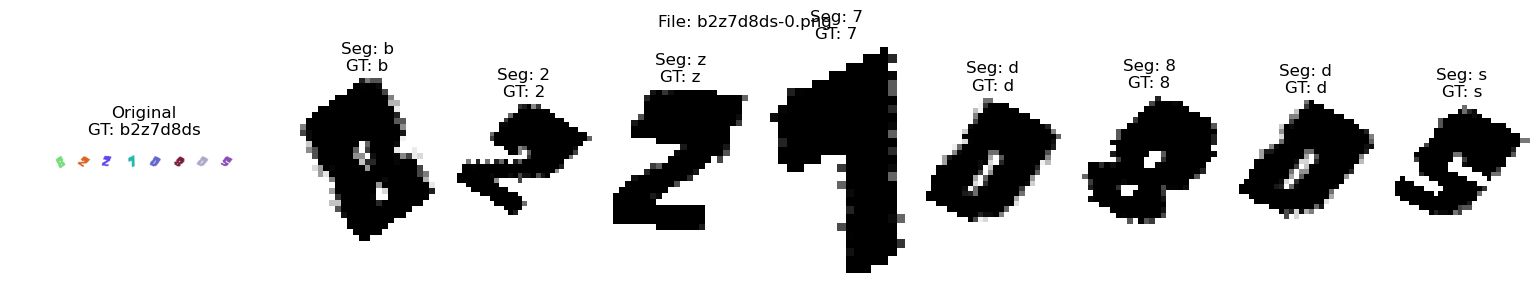

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).


/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


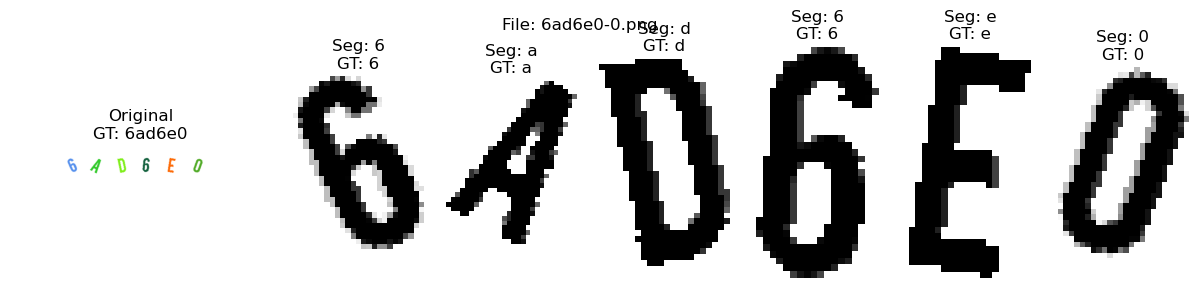

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).


/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


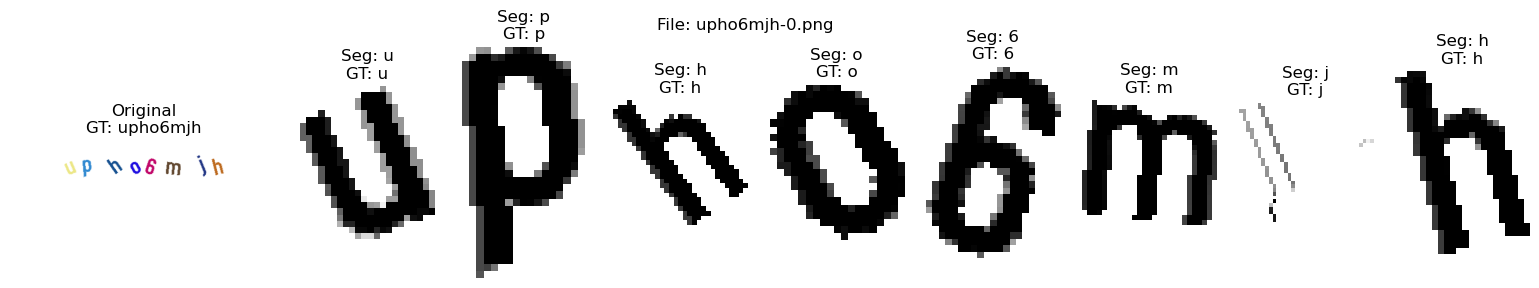

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


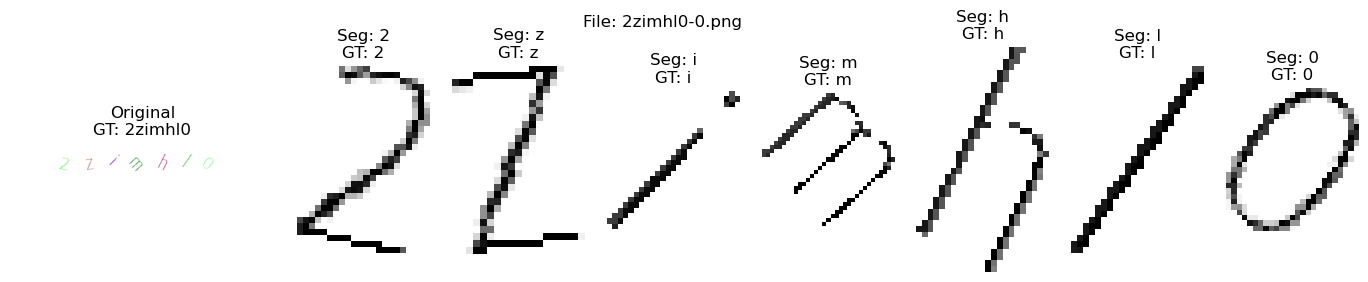

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).


/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


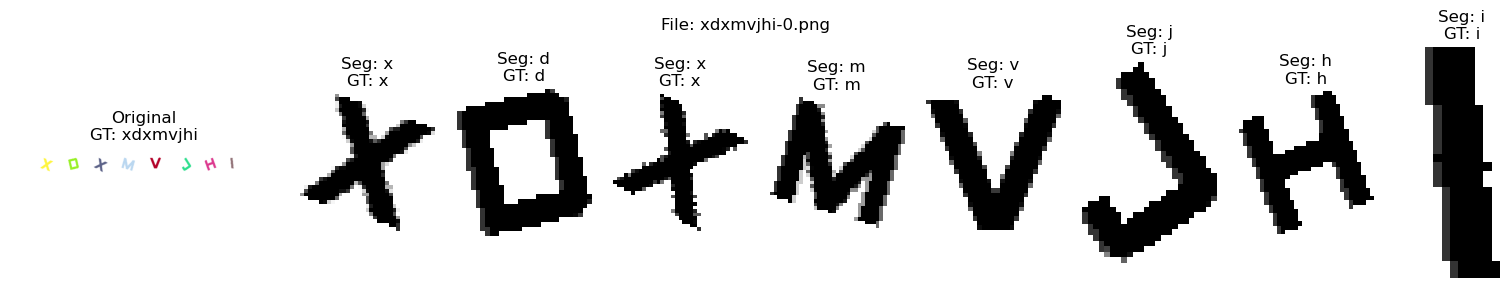

/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/3768890167.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).


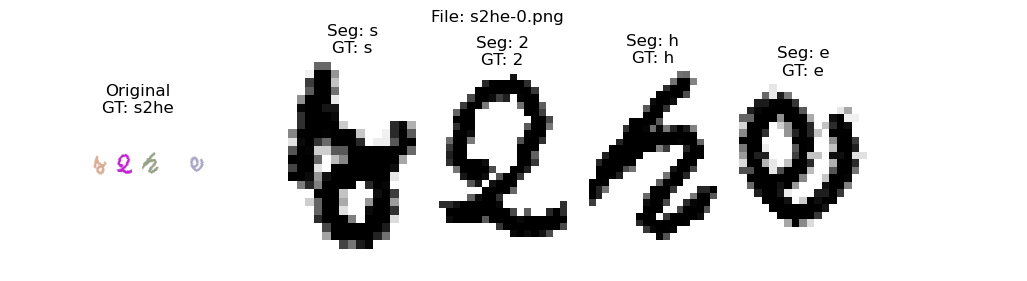

In [34]:
# Visualize original CAPTCHA alongside segmented characters for debugging
from matplotlib.gridspec import GridSpec

n_samples = 6  # how many CAPTCHAs to visualize
samples = train_img_files[:n_samples]

for img_path in samples:
    # Load original
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"[WARN] Could not read {img_path}")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Ground truth from filename
    gt_text = Path(img_path).stem.split('-')[0]

    # Segment characters using current pipeline
    char_images, char_labels = segment_characters(img_path)

    # Prepare layout: original on the left, characters on the right
    max_chars = max(len(char_images), len(gt_text)) if len(gt_text) > 0 else len(char_images)
    max_chars = max(5, max_chars)  # keep a minimum width for readability

    fig = plt.figure(figsize=(2 + max_chars * 2.2, 3))
    gs = GridSpec(1, max_chars + 1, width_ratios=[2] + [1] * max_chars, wspace=0.15)

    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_rgb)
    ax0.set_title(f"Original\nGT: {gt_text}")
    ax0.axis('off')

    # Segmented characters
    for j in range(max_chars):
        ax = fig.add_subplot(gs[0, j + 1])
        if j < len(char_images):
            ch_img = char_images[j]
            # robust grayscale for display
            if ch_img is None or ch_img.size == 0:
                ax.axis('off')
                continue
            if len(ch_img.shape) == 3:
                show_img = cv2.cvtColor(ch_img, cv2.COLOR_BGR2GRAY)
            else:
                show_img = ch_img

            # predicted label from segmentation alignment (label list) if available
            seg_label = char_labels[j] if j < len(char_labels) else '?'
            # expected char at this position (from GT) if available
            gt_char = gt_text[j] if j < len(gt_text) else ' '
            title = f"Seg: {seg_label}\nGT: {gt_char}"

            ax.imshow(show_img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(f"File: {Path(img_path).name}")
    plt.tight_layout()
    plt.show()

## 6. Character Recognition Model

CNN-based model for recognizing individual characters.

In [ ]:
class InvertedResidualBlock(nn.Module):
    """
    MobileNetV2-style block with depthwise separable convolutions.
    """
    def __init__(self, in_ch, out_ch, stride=1, expand_ratio=4):
        super().__init__()
        hidden_ch = in_ch * expand_ratio
        self.use_residual = (stride == 1 and in_ch == out_ch)

        self.conv = nn.Sequential(
            # Expand
            nn.Conv2d(in_ch, hidden_ch, 1, bias=False),
            nn.BatchNorm2d(hidden_ch),
            nn.ReLU6(inplace=True),
            # Depthwise
            nn.Conv2d(hidden_ch, hidden_ch, 3, stride=stride, padding=1, 
                     groups=hidden_ch, bias=False),
            nn.BatchNorm2d(hidden_ch),
            nn.ReLU6(inplace=True),
            # Project
            nn.Conv2d(hidden_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
        )

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        return self.conv(x)


class EfficientCaptchaCNN(nn.Module):
    def __init__(self, num_classes=36, dropout=0.5):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.features = nn.Sequential(
            InvertedResidualBlock(32, 32, stride=1, expand_ratio=1),   # 32x32
            InvertedResidualBlock(32, 64, stride=2, expand_ratio=4),   # 16x16
            InvertedResidualBlock(64, 64, stride=1, expand_ratio=4),   
            InvertedResidualBlock(64, 128, stride=2, expand_ratio=4),  # 8x8
            InvertedResidualBlock(128, 128, stride=1, expand_ratio=4), 
            InvertedResidualBlock(128, 256, stride=2, expand_ratio=4), # 4x4
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

# Initialize model
model = EfficientCaptchaCNN(num_classes=VOCAB_SIZE).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

EfficientCaptchaCNN(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (features): Sequential(
    (0): InvertedResidualBlock(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU6(inplace=True)
        (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): InvertedResidualBlock(
      (conv): Sequenti

## 7. Create DataLoaders

In [36]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True  # Drop last incomplete batch to avoid BatchNorm issues
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
    # No drop_last for test - we use model.eval() which disables BatchNorm training mode
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1463
Test batches: 376


## 8. Training Setup

In [37]:
# Training hyperparameters
NUM_EPOCHS = 20
BASE_LR = 3e-3
MAX_LR = 1e-2
WEIGHT_DECAY = 1e-4

# Loss and optimizer (label smoothing helps robustness)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

# OneCycleLR for fast convergence with higher LR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.2,
    div_factor=10.0,
    final_div_factor=100.0,
)

## 9. Training Loop

In [38]:
def train_epoch(model, loader, criterion, optimizer, device, scheduler=None, max_grad_norm=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for imgs, labels, _ in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        if max_grad_norm is not None and max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        # Scheduler step per batch (OneCycle)
        if scheduler is not None:
            scheduler.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(loader), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [39]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scheduler=scheduler)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print summary
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_char_recognition_model.pth')
        print(f"✓ New best model saved! Accuracy: {best_acc:.2f}%")

print(f"\nTraining complete! Best accuracy: {best_acc:.2f}%")


Epoch 1/20


Evaluating: 100%|██████████| 376/376 [00:24<00:00, 15.37it/s]



Train Loss: 2.4313, Train Acc: 44.22%
Test Loss: 1.9798, Test Acc: 62.26%
✓ New best model saved! Accuracy: 62.26%

Epoch 2/20


Evaluating: 100%|██████████| 376/376 [00:16<00:00, 22.54it/s]



Train Loss: 1.9837, Train Acc: 60.40%
Test Loss: 1.8481, Test Acc: 66.24%
✓ New best model saved! Accuracy: 66.24%

Epoch 3/20


Evaluating: 100%|██████████| 376/376 [00:16<00:00, 22.82it/s]



Train Loss: 1.9001, Train Acc: 63.32%
Test Loss: 1.7698, Test Acc: 68.17%
✓ New best model saved! Accuracy: 68.17%

Epoch 4/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 20.75it/s]



Train Loss: 1.8427, Train Acc: 65.24%
Test Loss: 1.7081, Test Acc: 70.92%
✓ New best model saved! Accuracy: 70.92%

Epoch 5/20


Evaluating: 100%|██████████| 376/376 [00:16<00:00, 22.97it/s]



Train Loss: 1.7916, Train Acc: 67.35%
Test Loss: 1.7027, Test Acc: 70.46%

Epoch 6/20


Evaluating: 100%|██████████| 376/376 [00:15<00:00, 23.72it/s]



Train Loss: 1.7570, Train Acc: 68.32%
Test Loss: 1.6381, Test Acc: 73.28%
✓ New best model saved! Accuracy: 73.28%

Epoch 7/20


Evaluating: 100%|██████████| 376/376 [00:16<00:00, 22.95it/s]



Train Loss: 1.7186, Train Acc: 69.62%
Test Loss: 1.5988, Test Acc: 74.09%
✓ New best model saved! Accuracy: 74.09%

Epoch 8/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 20.17it/s]



Train Loss: 1.6835, Train Acc: 70.88%
Test Loss: 1.5674, Test Acc: 75.20%
✓ New best model saved! Accuracy: 75.20%

Epoch 9/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 21.72it/s]



Train Loss: 1.6496, Train Acc: 71.98%
Test Loss: 1.5489, Test Acc: 75.76%
✓ New best model saved! Accuracy: 75.76%

Epoch 10/20


Evaluating: 100%|██████████| 376/376 [00:22<00:00, 16.76it/s]



Train Loss: 1.6183, Train Acc: 72.86%
Test Loss: 1.5840, Test Acc: 74.38%

Epoch 11/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 20.86it/s]



Train Loss: 1.5890, Train Acc: 73.87%
Test Loss: 1.4957, Test Acc: 77.62%
✓ New best model saved! Accuracy: 77.62%

Epoch 12/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 20.01it/s]



Train Loss: 1.5566, Train Acc: 75.10%
Test Loss: 1.4747, Test Acc: 78.08%
✓ New best model saved! Accuracy: 78.08%

Epoch 13/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 21.70it/s]



Train Loss: 1.5252, Train Acc: 76.07%
Test Loss: 1.4615, Test Acc: 79.09%
✓ New best model saved! Accuracy: 79.09%

Epoch 14/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 20.99it/s]



Train Loss: 1.4946, Train Acc: 76.94%
Test Loss: 1.4350, Test Acc: 79.51%
✓ New best model saved! Accuracy: 79.51%

Epoch 15/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 20.14it/s]



Train Loss: 1.4706, Train Acc: 77.49%
Test Loss: 1.4241, Test Acc: 79.75%
✓ New best model saved! Accuracy: 79.75%

Epoch 16/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 19.91it/s]



Train Loss: 1.4483, Train Acc: 78.32%
Test Loss: 1.4191, Test Acc: 79.87%
✓ New best model saved! Accuracy: 79.87%

Epoch 17/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 21.61it/s]



Train Loss: 1.4282, Train Acc: 78.85%
Test Loss: 1.4015, Test Acc: 80.42%
✓ New best model saved! Accuracy: 80.42%

Epoch 18/20


Evaluating: 100%|██████████| 376/376 [00:18<00:00, 20.49it/s]



Train Loss: 1.4076, Train Acc: 79.46%
Test Loss: 1.4027, Test Acc: 80.56%
✓ New best model saved! Accuracy: 80.56%

Epoch 19/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 21.40it/s]



Train Loss: 1.3997, Train Acc: 79.66%
Test Loss: 1.3989, Test Acc: 80.77%
✓ New best model saved! Accuracy: 80.77%

Epoch 20/20


Evaluating: 100%|██████████| 376/376 [00:17<00:00, 21.30it/s]


Train Loss: 1.3946, Train Acc: 80.00%
Test Loss: 1.3983, Test Acc: 80.73%

Training complete! Best accuracy: 80.77%


## 10. Visualize Training History

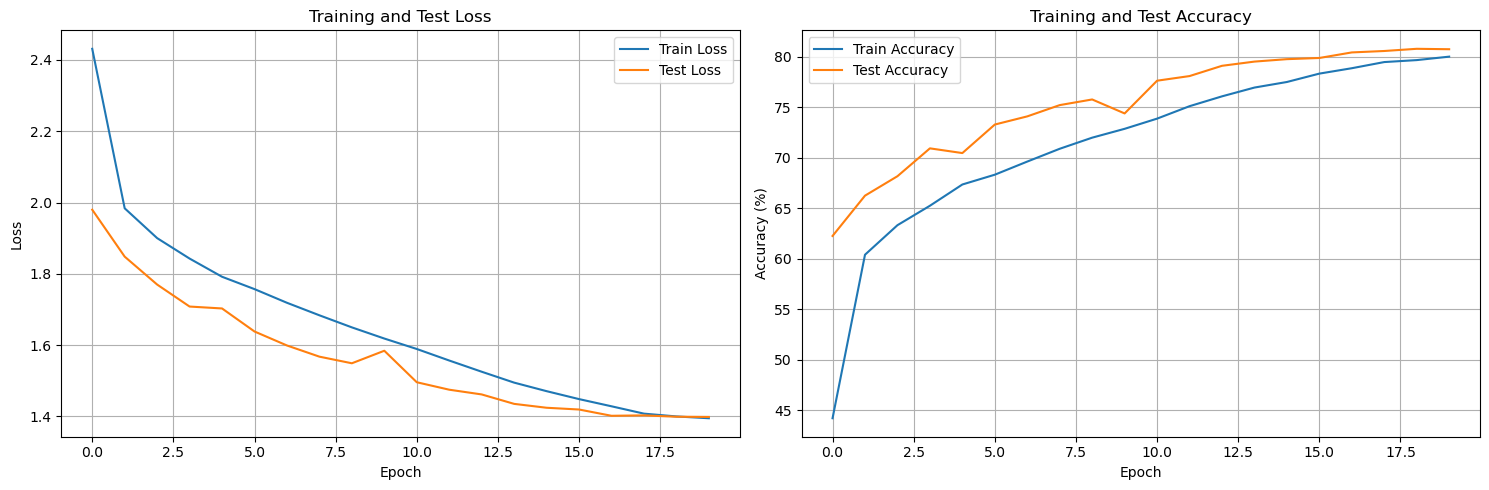

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Full CAPTCHA Recognition

Combine segmentation + recognition to decode complete CAPTCHAs.

In [41]:
def recognize_captcha(model, image_path, device, target_size=(32, 32)):
    """
    Recognize a full CAPTCHA by:
    1. Segmenting characters
    2. Recognizing each character with the CNN model
    3. Combining predictions
    """
    model.eval()
    
    # Segment characters
    char_images, _ = segment_characters(image_path)
    
    if not char_images:
        return "", []
    
    predictions = []
    confidences = []
    
    with torch.no_grad():
        for char_img in char_images:
            # Preprocess
            if len(char_img.shape) == 3:
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
            
            h, w = char_img.shape
            target_h, target_w = target_size
            
            # Check for invalid dimensions
            if h <= 0 or w <= 0:
                continue  # Skip invalid images
            
            scale = min(target_h / h, target_w / w)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Ensure minimum size of 1x1
            new_h = max(1, new_h)
            new_w = max(1, new_w)
            
            char_img = cv2.resize(char_img, (new_w, new_h))
            
            canvas = np.ones((target_h, target_w), dtype=np.uint8) * 255
            y_offset = (target_h - new_h) // 2
            x_offset = (target_w - new_w) // 2
            canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = char_img
            
            # Convert to tensor
            char_tensor = torch.from_numpy(canvas).float() / 255.0
            char_tensor = char_tensor.unsqueeze(0).repeat(3, 1, 1)  # 3 channels
            char_tensor = char_tensor.unsqueeze(0).to(device)  # Add batch dimension
            
            # Predict
            output = model(char_tensor)
            probs = F.softmax(output, dim=1)
            confidence, predicted = probs.max(1)
            
            pred_char = id2ch[predicted.item()]
            predictions.append(pred_char)
            confidences.append(confidence.item())
    
    result = ''.join(predictions)
    return result, confidences


def visualize_captcha_prediction(image_path, model, device):
    """
    Visualize CAPTCHA recognition result
    """
    # Get ground truth
    filename = Path(image_path).stem
    gt_text = filename.split('-')[0]
    
    # Predict
    pred_text, confidences = recognize_captcha(model, image_path, device)
    
    # Load and display image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(img_rgb)
    plt.title(f"Ground Truth: {gt_text}\nPrediction: {pred_text}\nConfidence: {np.mean(confidences):.3f}")
    plt.axis('off')
    plt.show()
    
    return gt_text, pred_text

## 12. Test on Sample CAPTCHAs

/var/folders/1j/bgj3j6y15c1_7y3s1yx9qvn40000gn/T/ipykernel_59836/1386466849.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_char_r

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


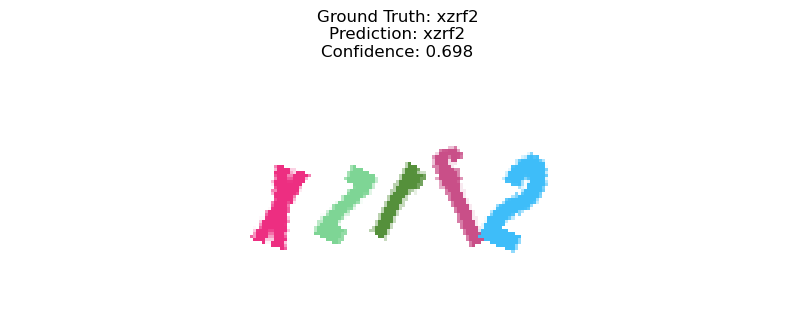

✓ Correct!

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).


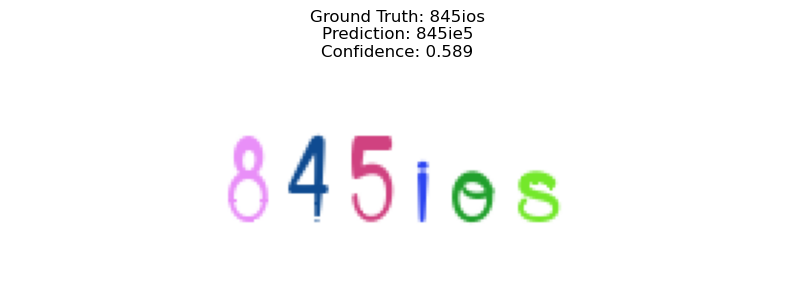

✗ Wrong. GT: 845ios, Pred: 845ie5

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).


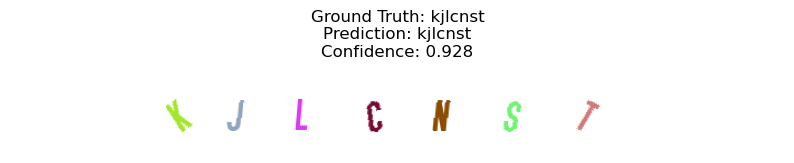

✓ Correct!

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).


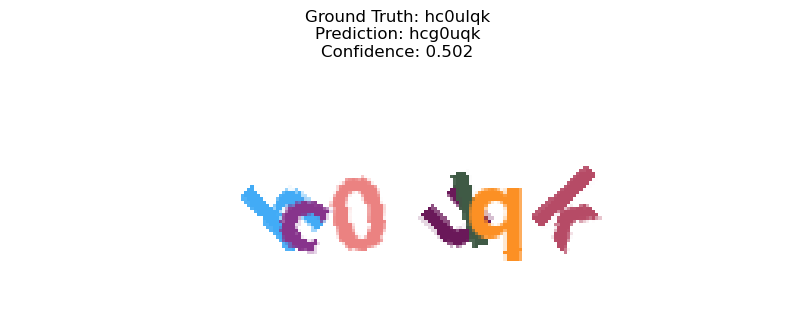

✗ Wrong. GT: hc0ulqk, Pred: hcg0uqk

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).


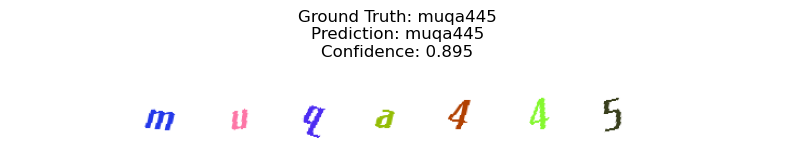

✓ Correct!


Accuracy: 3/5 = 60.00%


In [42]:
# Load best model
model.load_state_dict(torch.load('best_char_recognition_model.pth'))
model.eval()

# Test on a few samples
test_samples = test_img_files[:5]

correct = 0
total = len(test_samples)

for img_path in test_samples:
    gt, pred = visualize_captcha_prediction(img_path, model, device)
    if gt == pred:
        correct += 1
        print(f"✓ Correct!\n")
    else:
        print(f"✗ Wrong. GT: {gt}, Pred: {pred}\n")

print(f"\nAccuracy: {correct}/{total} = {100*correct/total:.2f}%")

## 13. Full Test Set Evaluation

In [46]:
def evaluate_full_captchas(model, img_paths, device):
    """
    Evaluate on full CAPTCHA images
    """
    model.eval()
    
    total = 0
    correct = 0
    char_total = 0
    char_correct = 0
    
    for img_path in tqdm(img_paths, desc="Evaluating CAPTCHAs"):
        try:
            filename = Path(img_path).stem
            gt_text = filename.split('-')[0].lower()
            
            pred_text, _ = recognize_captcha(model, img_path, device)
            pred_text = pred_text.lower()
            
            total += 1
            if gt_text == pred_text:
                correct += 1
            
            # Character-level accuracy
            for gt_ch, pred_ch in zip(gt_text, pred_text):
                char_total += 1
                if gt_ch == pred_ch:
                    char_correct += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    seq_acc = 100 * correct / total if total > 0 else 0
    char_acc = 100 * char_correct / char_total if char_total > 0 else 0
    
    print(f"\nResults on {total} CAPTCHAs:")
    print(f"Sequence Accuracy: {seq_acc:.2f}% ({correct}/{total})")
    print(f"Character Accuracy: {char_acc:.2f}% ({char_correct}/{char_total})")
    
    return seq_acc, char_acc


# Evaluate on test set
test_seq_acc, test_char_acc = evaluate_full_captchas(model, test_img_files, device)

Evaluating CAPTCHAs:   0%|          | 0/2000 [00:00<?, ?it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:   0%|          | 3/2000 [00:00<03:47,  8.77it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 7/2000 [00:00<02:38, 12.54it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   0%|          | 9/2000 [00:00<02:45, 12.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:   1%|          | 11/2000 [00:01<02:49, 11.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:   1%|          | 15/2000 [00:01<02:25, 13.66it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 161).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:   1%|          | 17/2000 [00:01<02:47, 11.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 21/2000 [00:01<02:29, 13.24it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|          | 23/2000 [00:01<02:34, 12.79it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 25/2000 [00:02<02:33, 12.89it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:   1%|▏         | 27/2000 [00:02<02:49, 11.64it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:   2%|▏         | 31/2000 [00:02<02:44, 11.94it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:   2%|▏         | 35/2000 [00:02<02:30, 13.06it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 89).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 71).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 37/2000 [00:03<02:23, 13.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:   2%|▏         | 39/2000 [00:03<02:39, 12.26it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 76).


Evaluating CAPTCHAs:   2%|▏         | 43/2000 [00:03<02:40, 12.17it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 45/2000 [00:03<02:34, 12.66it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   2%|▏         | 49/2000 [00:04<02:30, 12.93it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 51/2000 [00:04<02:32, 12.80it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   3%|▎         | 55/2000 [00:04<02:19, 13.97it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 57/2000 [00:04<02:21, 13.78it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:   3%|▎         | 59/2000 [00:04<02:26, 13.24it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:   3%|▎         | 63/2000 [00:05<02:18, 13.99it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 67/2000 [00:05<02:18, 13.99it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   3%|▎         | 69/2000 [00:05<02:11, 14.71it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   4%|▎         | 73/2000 [00:05<02:04, 15.52it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:   4%|▍         | 75/2000 [00:05<02:02, 15.68it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 11).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:   4%|▍         | 80/2000 [00:06<02:01, 15.77it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:   4%|▍         | 82/2000 [00:06<02:00, 15.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 90).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:   4%|▍         | 84/2000 [00:06<01:59, 15.99it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 88/2000 [00:06<02:38, 12.06it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   4%|▍         | 90/2000 [00:06<02:24, 13.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:   5%|▍         | 94/2000 [00:07<02:41, 11.79it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:   5%|▍         | 99/2000 [00:07<02:04, 15.30it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   5%|▌         | 101/2000 [00:07<02:05, 15.10it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:   5%|▌         | 105/2000 [00:07<02:00, 15.76it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:   5%|▌         | 109/2000 [00:08<02:13, 14.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   6%|▌         | 111/2000 [00:08<02:12, 14.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:   6%|▌         | 115/2000 [00:08<02:19, 13.49it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:   6%|▌         | 117/2000 [00:08<02:24, 13.04it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:   6%|▌         | 121/2000 [00:09<02:46, 11.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   6%|▋         | 125/2000 [00:09<02:18, 13.58it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:   6%|▋         | 129/2000 [00:09<02:08, 14.51it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 131/2000 [00:09<02:03, 15.14it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:   7%|▋         | 136/2000 [00:10<01:47, 17.35it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 140/2000 [00:10<01:47, 17.26it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:   7%|▋         | 145/2000 [00:10<01:39, 18.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:   7%|▋         | 147/2000 [00:10<01:40, 18.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 93).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:   8%|▊         | 152/2000 [00:11<01:51, 16.64it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 154/2000 [00:11<01:59, 15.45it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:   8%|▊         | 156/2000 [00:11<02:35, 11.83it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 158/2000 [00:11<02:35, 11.82it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 162/2000 [00:12<02:25, 12.59it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 165/2000 [00:12<02:03, 14.91it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   8%|▊         | 169/2000 [00:12<02:02, 14.95it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:   9%|▊         | 173/2000 [00:12<01:58, 15.42it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 177/2000 [00:12<01:50, 16.46it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:   9%|▉         | 179/2000 [00:13<01:49, 16.57it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:   9%|▉         | 184/2000 [00:13<01:45, 17.22it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 156).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:   9%|▉         | 189/2000 [00:13<01:42, 17.65it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 191/2000 [00:13<01:41, 17.74it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).


Evaluating CAPTCHAs:  10%|▉         | 195/2000 [00:14<01:55, 15.68it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  10%|▉         | 199/2000 [00:14<01:56, 15.46it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  10%|█         | 201/2000 [00:14<01:55, 15.60it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  10%|█         | 206/2000 [00:14<01:39, 17.97it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 102).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  10%|█         | 210/2000 [00:14<01:46, 16.80it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 212/2000 [00:15<02:16, 13.10it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  11%|█         | 217/2000 [00:15<01:55, 15.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 97).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  11%|█         | 221/2000 [00:15<02:00, 14.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  11%|█         | 223/2000 [00:15<02:05, 14.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 86).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  11%|█▏        | 225/2000 [00:16<02:07, 13.95it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 4).


Evaluating CAPTCHAs:  12%|█▏        | 230/2000 [00:16<02:02, 14.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 232/2000 [00:16<01:59, 14.77it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 3).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  12%|█▏        | 236/2000 [00:16<01:51, 15.88it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  12%|█▏        | 240/2000 [00:16<01:49, 16.11it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 244/2000 [00:17<02:01, 14.50it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 135).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  12%|█▏        | 247/2000 [00:17<01:46, 16.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 251/2000 [00:17<01:45, 16.65it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  13%|█▎        | 256/2000 [00:17<01:35, 18.25it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 259/2000 [00:18<01:27, 19.82it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  13%|█▎        | 261/2000 [00:18<01:43, 16.77it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  13%|█▎        | 265/2000 [00:18<01:51, 15.52it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  13%|█▎        | 269/2000 [00:18<01:55, 15.04it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  14%|█▎        | 271/2000 [00:18<01:51, 15.50it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 125).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  14%|█▍        | 276/2000 [00:19<01:47, 16.01it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 123).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 10).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 75).


Evaluating CAPTCHAs:  14%|█▍        | 278/2000 [00:19<01:54, 15.06it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).


Evaluating CAPTCHAs:  14%|█▍        | 282/2000 [00:19<01:51, 15.41it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  14%|█▍        | 285/2000 [00:19<01:42, 16.71it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  14%|█▍        | 289/2000 [00:19<01:45, 16.17it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:  15%|█▍        | 292/2000 [00:20<01:39, 17.19it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 83).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  15%|█▍        | 297/2000 [00:20<01:34, 17.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 302/2000 [00:20<01:32, 18.44it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  15%|█▌        | 306/2000 [00:20<01:35, 17.71it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  15%|█▌        | 309/2000 [00:21<01:29, 18.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:  16%|█▌        | 313/2000 [00:21<01:39, 16.90it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  16%|█▌        | 315/2000 [00:21<01:41, 16.59it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  16%|█▌        | 319/2000 [00:21<01:38, 17.12it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  16%|█▌        | 323/2000 [00:21<01:42, 16.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 328/2000 [00:22<01:35, 17.59it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 123).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  16%|█▋        | 330/2000 [00:22<01:35, 17.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  17%|█▋        | 334/2000 [00:22<01:41, 16.41it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  17%|█▋        | 338/2000 [00:22<01:46, 15.60it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  17%|█▋        | 340/2000 [00:22<01:46, 15.60it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 77).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  17%|█▋        | 344/2000 [00:23<01:52, 14.68it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 44).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  17%|█▋        | 348/2000 [00:23<01:50, 15.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 351/2000 [00:23<01:47, 15.31it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 54).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  18%|█▊        | 353/2000 [00:23<01:52, 14.61it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  18%|█▊        | 357/2000 [00:24<01:56, 14.14it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  18%|█▊        | 359/2000 [00:24<01:56, 14.11it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  18%|█▊        | 363/2000 [00:24<01:58, 13.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  18%|█▊        | 367/2000 [00:24<01:48, 15.00it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  18%|█▊        | 369/2000 [00:24<01:48, 15.09it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  19%|█▊        | 373/2000 [00:25<01:42, 15.88it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 58).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  19%|█▉        | 377/2000 [00:25<01:40, 16.18it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  19%|█▉        | 379/2000 [00:25<01:47, 15.08it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).


Evaluating CAPTCHAs:  19%|█▉        | 383/2000 [00:25<01:50, 14.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  19%|█▉        | 387/2000 [00:26<01:50, 14.56it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 390/2000 [00:26<01:41, 15.89it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 394/2000 [00:26<01:41, 15.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  20%|█▉        | 396/2000 [00:26<01:43, 15.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  20%|██        | 400/2000 [00:26<01:37, 16.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  20%|██        | 404/2000 [00:27<01:37, 16.37it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  20%|██        | 408/2000 [00:27<01:40, 15.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 51).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  21%|██        | 412/2000 [00:27<01:44, 15.24it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 414/2000 [00:27<01:47, 14.74it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 80).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  21%|██        | 418/2000 [00:28<01:44, 15.20it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  21%|██        | 422/2000 [00:28<01:40, 15.72it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  21%|██▏       | 427/2000 [00:28<01:29, 17.56it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  21%|██▏       | 429/2000 [00:28<01:32, 16.99it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 433/2000 [00:29<01:42, 15.27it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 435/2000 [00:29<01:44, 15.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 439/2000 [00:29<01:40, 15.61it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 5).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  22%|██▏       | 443/2000 [00:29<01:40, 15.56it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  22%|██▏       | 445/2000 [00:29<01:38, 15.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  22%|██▏       | 449/2000 [00:30<01:40, 15.41it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  23%|██▎       | 454/2000 [00:30<01:31, 16.82it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  23%|██▎       | 458/2000 [00:30<01:36, 15.99it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 0).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  23%|██▎       | 461/2000 [00:30<01:29, 17.18it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  23%|██▎       | 465/2000 [00:31<01:32, 16.61it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  23%|██▎       | 469/2000 [00:31<01:32, 16.48it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▎       | 472/2000 [00:31<01:22, 18.59it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 476/2000 [00:31<01:32, 16.49it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  24%|██▍       | 480/2000 [00:31<01:31, 16.58it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 482/2000 [00:32<01:35, 15.86it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 487/2000 [00:32<01:29, 16.97it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 106).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  24%|██▍       | 490/2000 [00:32<01:24, 17.95it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  25%|██▍       | 494/2000 [00:32<01:31, 16.53it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▍       | 496/2000 [00:32<01:38, 15.32it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  25%|██▌       | 500/2000 [00:33<01:30, 16.66it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  25%|██▌       | 504/2000 [00:33<01:33, 16.08it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 84).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  25%|██▌       | 507/2000 [00:33<01:32, 16.19it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 511/2000 [00:33<01:36, 15.47it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 513/2000 [00:33<01:32, 16.08it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  26%|██▌       | 517/2000 [00:34<01:33, 15.78it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▌       | 521/2000 [00:34<01:24, 17.42it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  26%|██▋       | 525/2000 [00:34<01:23, 17.57it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  26%|██▋       | 529/2000 [00:34<01:32, 15.82it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 531/2000 [00:35<01:32, 15.94it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 535/2000 [00:35<01:41, 14.39it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  27%|██▋       | 537/2000 [00:35<01:52, 13.05it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  27%|██▋       | 541/2000 [00:35<01:37, 15.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  27%|██▋       | 543/2000 [00:35<01:41, 14.38it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  27%|██▋       | 547/2000 [00:36<01:36, 15.06it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  28%|██▊       | 551/2000 [00:36<01:33, 15.51it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  28%|██▊       | 553/2000 [00:36<01:35, 15.18it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  28%|██▊       | 558/2000 [00:36<01:22, 17.40it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 562/2000 [00:37<01:31, 15.77it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 564/2000 [00:37<01:36, 14.88it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 153).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  28%|██▊       | 568/2000 [00:37<01:37, 14.72it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  28%|██▊       | 570/2000 [00:37<02:03, 11.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 76).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▊       | 574/2000 [00:38<01:48, 13.13it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 578/2000 [00:38<01:31, 15.47it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 581/2000 [00:38<01:20, 17.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 9).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 586/2000 [00:38<01:18, 17.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  29%|██▉       | 588/2000 [00:38<01:18, 18.09it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  30%|██▉       | 592/2000 [00:39<01:26, 16.25it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 596/2000 [00:39<01:23, 16.81it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  30%|██▉       | 598/2000 [00:39<01:29, 15.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  30%|███       | 602/2000 [00:39<01:25, 16.26it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  30%|███       | 604/2000 [00:39<01:32, 15.05it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  30%|███       | 608/2000 [00:40<01:39, 13.97it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  31%|███       | 612/2000 [00:40<01:31, 15.17it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  31%|███       | 616/2000 [00:40<01:29, 15.42it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 99).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  31%|███       | 618/2000 [00:40<01:28, 15.63it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  31%|███       | 622/2000 [00:41<01:30, 15.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  31%|███       | 624/2000 [00:41<01:32, 14.85it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  31%|███▏      | 628/2000 [00:41<01:34, 14.49it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  32%|███▏      | 630/2000 [00:41<01:35, 14.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  32%|███▏      | 634/2000 [00:41<01:31, 14.92it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  32%|███▏      | 638/2000 [00:42<01:28, 15.35it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  32%|███▏      | 642/2000 [00:42<01:24, 16.13it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  32%|███▏      | 645/2000 [00:42<01:19, 17.02it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  32%|███▏      | 649/2000 [00:42<01:21, 16.67it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 654/2000 [00:42<01:10, 19.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 56).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  33%|███▎      | 658/2000 [00:43<01:16, 17.58it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  33%|███▎      | 660/2000 [00:43<01:19, 16.90it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  33%|███▎      | 664/2000 [00:43<01:20, 16.63it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  33%|███▎      | 668/2000 [00:43<01:18, 16.90it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  34%|███▎      | 673/2000 [00:44<01:16, 17.24it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 71).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  34%|███▍      | 675/2000 [00:44<01:22, 16.03it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  34%|███▍      | 679/2000 [00:44<01:17, 17.05it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  34%|███▍      | 682/2000 [00:44<01:13, 17.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 70).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 223).


Evaluating CAPTCHAs:  34%|███▍      | 686/2000 [00:44<01:22, 15.85it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 691/2000 [00:45<01:14, 17.49it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▍      | 693/2000 [00:45<01:20, 16.26it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  35%|███▍      | 697/2000 [00:45<01:21, 15.92it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 701/2000 [00:45<01:24, 15.46it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 72).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  35%|███▌      | 705/2000 [00:46<01:20, 16.04it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  35%|███▌      | 707/2000 [00:46<01:22, 15.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  36%|███▌      | 711/2000 [00:46<01:23, 15.50it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  36%|███▌      | 715/2000 [00:46<01:21, 15.78it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 65).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 115).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▌      | 717/2000 [00:46<01:23, 15.36it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 90).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 83).


Evaluating CAPTCHAs:  36%|███▌      | 721/2000 [00:47<01:15, 17.04it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  36%|███▋      | 725/2000 [00:47<01:19, 15.98it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  36%|███▋      | 729/2000 [00:47<01:17, 16.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  37%|███▋      | 733/2000 [00:47<01:15, 16.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 737/2000 [00:48<01:10, 17.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  37%|███▋      | 740/2000 [00:48<01:07, 18.75it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 70).


Evaluating CAPTCHAs:  37%|███▋      | 745/2000 [00:48<01:07, 18.49it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).


Evaluating CAPTCHAs:  38%|███▊      | 750/2000 [00:48<01:04, 19.32it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 752/2000 [00:48<01:06, 18.85it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 149).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  38%|███▊      | 756/2000 [00:49<01:23, 14.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 55).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 759/2000 [00:49<01:18, 15.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  38%|███▊      | 764/2000 [00:49<01:11, 17.18it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  38%|███▊      | 766/2000 [00:49<01:12, 17.01it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  38%|███▊      | 770/2000 [00:49<01:14, 16.56it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▊      | 774/2000 [00:50<01:08, 17.82it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 87).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  39%|███▉      | 778/2000 [00:50<01:07, 18.13it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  39%|███▉      | 782/2000 [00:50<01:14, 16.42it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).


Evaluating CAPTCHAs:  39%|███▉      | 785/2000 [00:50<01:07, 17.97it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 49).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).


Evaluating CAPTCHAs:  39%|███▉      | 789/2000 [00:51<01:12, 16.72it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  40%|███▉      | 793/2000 [00:51<01:10, 17.01it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  40%|███▉      | 797/2000 [00:51<01:11, 16.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  40%|███▉      | 799/2000 [00:51<01:10, 17.05it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  40%|████      | 803/2000 [00:51<01:13, 16.28it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  40%|████      | 808/2000 [00:52<01:09, 17.10it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 47).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  41%|████      | 812/2000 [00:52<01:13, 16.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  41%|████      | 814/2000 [00:52<01:15, 15.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 3).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  41%|████      | 816/2000 [00:52<01:18, 15.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  41%|████      | 821/2000 [00:53<01:13, 15.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 62).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  41%|████▏     | 825/2000 [00:53<01:11, 16.42it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  41%|████▏     | 827/2000 [00:53<01:09, 16.86it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  42%|████▏     | 832/2000 [00:53<01:10, 16.51it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  42%|████▏     | 834/2000 [00:53<01:13, 15.83it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  42%|████▏     | 838/2000 [00:54<01:23, 13.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  42%|████▏     | 840/2000 [00:54<01:23, 13.83it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  42%|████▏     | 844/2000 [00:54<01:20, 14.32it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▏     | 848/2000 [00:54<01:20, 14.33it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  42%|████▎     | 850/2000 [00:55<01:22, 13.94it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  43%|████▎     | 855/2000 [00:55<01:10, 16.15it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  43%|████▎     | 859/2000 [00:55<01:11, 15.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 76).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 862/2000 [00:55<01:05, 17.46it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  43%|████▎     | 866/2000 [00:55<01:10, 16.06it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  44%|████▎     | 871/2000 [00:56<01:01, 18.51it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  44%|████▎     | 874/2000 [00:56<00:58, 19.20it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  44%|████▍     | 878/2000 [00:56<01:07, 16.67it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 134).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 59).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 882/2000 [00:56<01:09, 15.99it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 884/2000 [00:56<01:09, 16.08it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  44%|████▍     | 888/2000 [00:57<01:12, 15.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 77).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  44%|████▍     | 890/2000 [00:57<01:09, 15.91it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  45%|████▍     | 894/2000 [00:57<01:12, 15.33it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▍     | 899/2000 [00:57<01:06, 16.47it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  45%|████▌     | 901/2000 [00:58<01:06, 16.53it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  45%|████▌     | 906/2000 [00:58<01:04, 16.90it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).


Evaluating CAPTCHAs:  46%|████▌     | 910/2000 [00:58<01:07, 16.16it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 912/2000 [00:58<01:09, 15.69it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).


Evaluating CAPTCHAs:  46%|████▌     | 916/2000 [00:59<01:06, 16.41it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 66).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 920/2000 [00:59<01:06, 16.34it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 64).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▌     | 924/2000 [00:59<01:05, 16.44it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 928/2000 [00:59<01:02, 17.19it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 140).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  46%|████▋     | 930/2000 [00:59<01:07, 15.84it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  47%|████▋     | 935/2000 [01:00<01:02, 16.97it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 937/2000 [01:00<01:07, 15.67it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  47%|████▋     | 941/2000 [01:00<01:08, 15.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  47%|████▋     | 944/2000 [01:00<01:03, 16.60it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 139).


Evaluating CAPTCHAs:  47%|████▋     | 948/2000 [01:01<01:11, 14.64it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 3).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  48%|████▊     | 952/2000 [01:01<01:07, 15.43it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 956/2000 [01:01<01:01, 16.97it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  48%|████▊     | 958/2000 [01:01<00:58, 17.75it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  48%|████▊     | 963/2000 [01:01<00:56, 18.24it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 100).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 66).


Evaluating CAPTCHAs:  48%|████▊     | 965/2000 [01:02<01:03, 16.31it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 63).


Evaluating CAPTCHAs:  49%|████▊     | 971/2000 [01:02<00:53, 19.21it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 976/2000 [01:02<00:55, 18.44it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  49%|████▉     | 978/2000 [01:02<01:00, 16.89it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 11).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  49%|████▉     | 983/2000 [01:02<00:55, 18.20it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 11).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  49%|████▉     | 986/2000 [01:03<00:54, 18.44it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  50%|████▉     | 990/2000 [01:03<01:05, 15.43it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  50%|████▉     | 994/2000 [01:03<01:01, 16.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 55).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  50%|████▉     | 997/2000 [01:03<00:59, 16.88it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1001/2000 [01:04<01:01, 16.13it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).


Evaluating CAPTCHAs:  50%|█████     | 1005/2000 [01:04<01:00, 16.51it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 62).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  50%|█████     | 1007/2000 [01:04<01:00, 16.51it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  51%|█████     | 1011/2000 [01:04<01:01, 16.03it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████     | 1015/2000 [01:04<01:00, 16.19it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  51%|█████     | 1019/2000 [01:05<00:57, 16.92it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 76).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  51%|█████     | 1023/2000 [01:05<00:59, 16.39it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  51%|█████▏    | 1025/2000 [01:05<01:05, 14.78it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1030/2000 [01:05<00:55, 17.48it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  52%|█████▏    | 1033/2000 [01:06<00:48, 19.74it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 166).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1039/2000 [01:06<00:50, 18.98it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1042/2000 [01:06<00:51, 18.63it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  52%|█████▏    | 1044/2000 [01:06<00:53, 17.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  52%|█████▏    | 1048/2000 [01:06<01:00, 15.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1053/2000 [01:07<00:52, 18.21it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 192).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  53%|█████▎    | 1057/2000 [01:07<00:54, 17.18it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  53%|█████▎    | 1060/2000 [01:07<00:51, 18.15it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  53%|█████▎    | 1064/2000 [01:07<00:50, 18.45it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  53%|█████▎    | 1069/2000 [01:08<00:51, 18.03it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▎    | 1071/2000 [01:08<00:55, 16.84it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  54%|█████▍    | 1075/2000 [01:08<00:56, 16.26it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  54%|█████▍    | 1079/2000 [01:08<00:58, 15.65it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 12).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  54%|█████▍    | 1082/2000 [01:08<00:55, 16.67it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 79).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  54%|█████▍    | 1086/2000 [01:09<00:55, 16.57it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 68).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  55%|█████▍    | 1090/2000 [01:09<00:56, 16.10it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  55%|█████▍    | 1093/2000 [01:09<00:50, 18.10it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 69).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  55%|█████▍    | 1097/2000 [01:09<00:51, 17.37it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 87).


Evaluating CAPTCHAs:  55%|█████▌    | 1100/2000 [01:09<00:53, 16.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  55%|█████▌    | 1105/2000 [01:10<00:49, 18.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  55%|█████▌    | 1107/2000 [01:10<00:54, 16.28it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 197).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  56%|█████▌    | 1113/2000 [01:10<00:47, 18.87it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1118/2000 [01:10<00:47, 18.70it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 8).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▌    | 1122/2000 [01:11<00:50, 17.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 85).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1125/2000 [01:11<00:46, 18.77it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 62).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  56%|█████▋    | 1130/2000 [01:11<00:47, 18.33it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1132/2000 [01:11<00:47, 18.36it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  57%|█████▋    | 1136/2000 [01:11<00:49, 17.46it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  57%|█████▋    | 1140/2000 [01:12<00:52, 16.51it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  57%|█████▋    | 1142/2000 [01:12<00:51, 16.76it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 69).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  57%|█████▋    | 1146/2000 [01:12<00:53, 15.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  57%|█████▊    | 1150/2000 [01:12<00:54, 15.67it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1152/2000 [01:12<00:52, 16.15it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 72).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  58%|█████▊    | 1156/2000 [01:13<01:01, 13.66it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  58%|█████▊    | 1158/2000 [01:13<00:55, 15.04it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  58%|█████▊    | 1162/2000 [01:13<00:54, 15.29it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  58%|█████▊    | 1167/2000 [01:13<00:47, 17.59it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  58%|█████▊    | 1170/2000 [01:14<00:44, 18.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  59%|█████▊    | 1174/2000 [01:14<00:45, 18.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1178/2000 [01:14<00:53, 15.48it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 10).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  59%|█████▉    | 1180/2000 [01:14<00:51, 16.01it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  59%|█████▉    | 1184/2000 [01:14<00:53, 15.24it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 105).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  59%|█████▉    | 1188/2000 [01:15<00:54, 14.97it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  60%|█████▉    | 1190/2000 [01:15<00:51, 15.87it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 89).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 7).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  60%|█████▉    | 1194/2000 [01:15<00:49, 16.35it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  60%|█████▉    | 1198/2000 [01:15<00:46, 17.09it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1203/2000 [01:16<00:48, 16.51it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  60%|██████    | 1205/2000 [01:16<00:48, 16.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 81).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  60%|██████    | 1210/2000 [01:16<00:45, 17.32it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  61%|██████    | 1213/2000 [01:16<00:44, 17.67it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  61%|██████    | 1217/2000 [01:16<00:43, 17.80it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  61%|██████    | 1221/2000 [01:17<00:45, 17.10it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  61%|██████▏   | 1225/2000 [01:17<00:47, 16.18it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 71).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  61%|██████▏   | 1228/2000 [01:17<00:45, 16.92it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  62%|██████▏   | 1231/2000 [01:17<00:45, 17.00it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  62%|██████▏   | 1235/2000 [01:17<00:47, 16.10it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  62%|██████▏   | 1240/2000 [01:18<00:45, 16.70it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  62%|██████▏   | 1243/2000 [01:18<00:44, 17.16it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 4).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1247/2000 [01:18<00:48, 15.65it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 120).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  62%|██████▏   | 1249/2000 [01:18<00:49, 15.12it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  63%|██████▎   | 1253/2000 [01:19<00:46, 16.23it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 6).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 67).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  63%|██████▎   | 1257/2000 [01:19<00:44, 16.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 56).


Evaluating CAPTCHAs:  63%|██████▎   | 1261/2000 [01:19<00:40, 18.09it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1266/2000 [01:19<00:41, 17.76it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 81).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 13).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 48).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  63%|██████▎   | 1269/2000 [01:19<00:38, 18.87it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  64%|██████▎   | 1273/2000 [01:20<00:42, 16.99it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 41).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1277/2000 [01:20<00:45, 15.73it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 15).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1279/2000 [01:20<00:43, 16.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 67).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1284/2000 [01:20<00:45, 15.60it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 49).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  64%|██████▍   | 1287/2000 [01:21<00:43, 16.32it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  65%|██████▍   | 1292/2000 [01:21<00:38, 18.41it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▍   | 1294/2000 [01:21<00:41, 16.95it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  65%|██████▍   | 1299/2000 [01:21<00:39, 17.96it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  65%|██████▌   | 1301/2000 [01:21<00:41, 16.93it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  65%|██████▌   | 1305/2000 [01:22<00:41, 16.63it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 56).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  65%|██████▌   | 1309/2000 [01:22<00:43, 15.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  66%|██████▌   | 1313/2000 [01:22<00:40, 17.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  66%|██████▌   | 1317/2000 [01:22<00:38, 17.64it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1321/2000 [01:23<00:38, 17.72it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  66%|██████▌   | 1324/2000 [01:23<00:37, 18.18it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 55).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 64).


Evaluating CAPTCHAs:  66%|██████▋   | 1328/2000 [01:23<00:41, 16.19it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1332/2000 [01:23<00:40, 16.63it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).


Evaluating CAPTCHAs:  67%|██████▋   | 1335/2000 [01:23<00:38, 17.11it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1339/2000 [01:24<00:41, 15.82it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 32).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 60).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  67%|██████▋   | 1341/2000 [01:24<00:42, 15.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  67%|██████▋   | 1346/2000 [01:24<00:38, 17.01it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 95).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1350/2000 [01:24<00:39, 16.55it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  68%|██████▊   | 1354/2000 [01:25<00:40, 15.85it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1356/2000 [01:25<00:43, 14.66it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 105).


Evaluating CAPTCHAs:  68%|██████▊   | 1362/2000 [01:25<00:34, 18.29it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 81).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  68%|██████▊   | 1364/2000 [01:25<00:37, 17.00it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  68%|██████▊   | 1368/2000 [01:25<00:36, 17.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 53).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▊   | 1372/2000 [01:26<00:36, 17.02it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 56).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1377/2000 [01:26<00:34, 17.90it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1379/2000 [01:26<00:36, 16.92it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 141).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1385/2000 [01:26<00:34, 18.02it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 69).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  69%|██████▉   | 1389/2000 [01:27<00:34, 17.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 7).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1393/2000 [01:27<00:33, 18.25it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  70%|██████▉   | 1395/2000 [01:27<00:33, 17.89it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  70%|███████   | 1400/2000 [01:27<00:36, 16.40it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 92).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  70%|███████   | 1402/2000 [01:27<00:38, 15.37it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 74).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  70%|███████   | 1405/2000 [01:28<00:35, 16.83it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  70%|███████   | 1409/2000 [01:28<00:49, 11.96it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1411/2000 [01:28<00:59,  9.90it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 85).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  71%|███████   | 1415/2000 [01:29<00:52, 11.22it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1419/2000 [01:29<00:42, 13.75it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 110).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 63).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  71%|███████   | 1423/2000 [01:29<00:38, 14.91it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  71%|███████▏  | 1425/2000 [01:29<00:36, 15.81it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  71%|███████▏  | 1429/2000 [01:30<00:43, 13.09it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 43).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1431/2000 [01:30<00:42, 13.28it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  72%|███████▏  | 1433/2000 [01:30<01:05,  8.72it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 8).


Evaluating CAPTCHAs:  72%|███████▏  | 1435/2000 [01:30<01:00,  9.41it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 18).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 89).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  72%|███████▏  | 1437/2000 [01:31<00:58,  9.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  72%|███████▏  | 1441/2000 [01:31<00:53, 10.39it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  72%|███████▏  | 1445/2000 [01:31<00:44, 12.56it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 82).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 58).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  72%|███████▏  | 1447/2000 [01:31<00:41, 13.32it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 45).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).


Evaluating CAPTCHAs:  73%|███████▎  | 1451/2000 [01:32<00:36, 15.19it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1456/2000 [01:32<00:31, 17.14it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1460/2000 [01:32<00:32, 16.66it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  73%|███████▎  | 1462/2000 [01:32<00:31, 17.16it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  73%|███████▎  | 1466/2000 [01:32<00:31, 16.71it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▎  | 1470/2000 [01:33<00:33, 15.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  74%|███████▎  | 1474/2000 [01:33<00:33, 15.89it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 105).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  74%|███████▍  | 1476/2000 [01:33<00:32, 15.95it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  74%|███████▍  | 1480/2000 [01:33<00:34, 15.21it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 17).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1484/2000 [01:34<00:31, 16.24it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  74%|███████▍  | 1488/2000 [01:34<00:30, 16.93it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 34).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  74%|███████▍  | 1490/2000 [01:34<00:29, 17.34it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 46).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  75%|███████▍  | 1494/2000 [01:34<00:36, 13.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).


Evaluating CAPTCHAs:  75%|███████▍  | 1497/2000 [01:34<00:30, 16.30it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 110).


Evaluating CAPTCHAs:  75%|███████▌  | 1501/2000 [01:35<00:41, 12.15it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  75%|███████▌  | 1503/2000 [01:35<00:39, 12.45it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  75%|███████▌  | 1507/2000 [01:35<00:34, 14.30it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 7).


Evaluating CAPTCHAs:  75%|███████▌  | 1509/2000 [01:35<00:34, 14.18it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  76%|███████▌  | 1513/2000 [01:36<00:32, 15.17it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  76%|███████▌  | 1515/2000 [01:36<00:31, 15.44it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  76%|███████▌  | 1519/2000 [01:36<00:32, 14.90it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 6).


Evaluating CAPTCHAs:  76%|███████▌  | 1523/2000 [01:36<00:30, 15.49it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  76%|███████▋  | 1525/2000 [01:37<00:41, 11.52it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  76%|███████▋  | 1527/2000 [01:37<00:37, 12.51it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1532/2000 [01:37<00:32, 14.38it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 70).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1536/2000 [01:37<00:29, 15.62it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 65).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  77%|███████▋  | 1538/2000 [01:37<00:29, 15.41it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 57).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  77%|███████▋  | 1542/2000 [01:38<00:30, 15.15it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 142).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 64).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).


Evaluating CAPTCHAs:  77%|███████▋  | 1546/2000 [01:38<00:30, 14.95it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 88).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).


Evaluating CAPTCHAs:  77%|███████▋  | 1549/2000 [01:38<00:26, 17.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 73).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  78%|███████▊  | 1553/2000 [01:38<00:26, 16.69it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 43).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  78%|███████▊  | 1555/2000 [01:38<00:32, 13.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 49).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  78%|███████▊  | 1559/2000 [01:39<00:30, 14.36it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  78%|███████▊  | 1563/2000 [01:39<00:40, 10.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  78%|███████▊  | 1565/2000 [01:39<00:39, 10.94it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  78%|███████▊  | 1569/2000 [01:40<00:34, 12.35it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 40).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▊  | 1573/2000 [01:40<00:30, 13.92it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 58).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 37).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1575/2000 [01:40<00:29, 14.60it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  79%|███████▉  | 1579/2000 [01:40<00:26, 15.94it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1581/2000 [01:41<00:32, 12.82it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 117).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  79%|███████▉  | 1585/2000 [01:41<00:28, 14.75it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  79%|███████▉  | 1589/2000 [01:41<00:27, 14.74it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 105).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  80%|███████▉  | 1591/2000 [01:41<00:28, 14.34it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 19).


Evaluating CAPTCHAs:  80%|███████▉  | 1596/2000 [01:41<00:25, 15.61it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 16).


Evaluating CAPTCHAs:  80%|████████  | 1600/2000 [01:42<00:26, 15.33it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 19).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1602/2000 [01:42<00:24, 16.32it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  80%|████████  | 1606/2000 [01:42<00:25, 15.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  80%|████████  | 1610/2000 [01:42<00:24, 15.65it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  81%|████████  | 1614/2000 [01:43<00:23, 16.22it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 76).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 62).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████  | 1617/2000 [01:43<00:20, 18.62it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 0).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 45).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  81%|████████  | 1621/2000 [01:43<00:21, 17.78it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).


Evaluating CAPTCHAs:  81%|████████▏ | 1626/2000 [01:43<00:21, 17.33it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 29).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  81%|████████▏ | 1628/2000 [01:43<00:22, 16.39it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 58).


Evaluating CAPTCHAs:  82%|████████▏ | 1632/2000 [01:44<00:21, 16.80it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 47).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  82%|████████▏ | 1636/2000 [01:44<00:22, 16.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 4).


Evaluating CAPTCHAs:  82%|████████▏ | 1640/2000 [01:44<00:22, 16.08it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 67).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 109).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  82%|████████▏ | 1642/2000 [01:44<00:21, 16.67it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 97).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  82%|████████▏ | 1647/2000 [01:45<00:21, 16.78it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 17).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1651/2000 [01:45<00:19, 17.55it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 53).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 118).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1654/2000 [01:45<00:20, 17.16it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 123).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1659/2000 [01:45<00:19, 17.23it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  83%|████████▎ | 1661/2000 [01:45<00:20, 16.59it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 37).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  83%|████████▎ | 1665/2000 [01:46<00:20, 16.36it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 16).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 17).


Evaluating CAPTCHAs:  84%|████████▎ | 1670/2000 [01:46<00:17, 19.00it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 60).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 42).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 12).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▎ | 1672/2000 [01:46<00:19, 16.52it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1676/2000 [01:46<00:20, 15.82it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 32).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 126).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1678/2000 [01:46<00:21, 14.64it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).


Evaluating CAPTCHAs:  84%|████████▍ | 1682/2000 [01:47<00:19, 15.91it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 53).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 3).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1687/2000 [01:47<00:18, 16.77it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 77).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  84%|████████▍ | 1690/2000 [01:47<00:18, 17.08it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 91).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 74).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1694/2000 [01:47<00:19, 15.87it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 91).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▍ | 1697/2000 [01:48<00:17, 16.87it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1701/2000 [01:48<00:17, 17.55it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 41).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 51).


Evaluating CAPTCHAs:  85%|████████▌ | 1705/2000 [01:48<00:17, 16.44it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 52).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 76).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  85%|████████▌ | 1707/2000 [01:48<00:19, 14.98it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1712/2000 [01:48<00:15, 18.22it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  86%|████████▌ | 1715/2000 [01:49<00:14, 19.26it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).


Evaluating CAPTCHAs:  86%|████████▌ | 1719/2000 [01:49<00:22, 12.61it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1721/2000 [01:49<00:20, 13.34it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▌ | 1723/2000 [01:49<00:23, 11.56it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  86%|████████▋ | 1725/2000 [01:50<00:25, 10.97it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1727/2000 [01:50<00:33,  8.09it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  86%|████████▋ | 1728/2000 [01:50<00:33,  8.19it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 14).


Evaluating CAPTCHAs:  87%|████████▋ | 1732/2000 [01:50<00:24, 10.89it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 78).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  87%|████████▋ | 1736/2000 [01:51<00:20, 13.14it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 16).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 14).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 28).
[INFO] Detected 4 characters — using 5 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1740/2000 [01:51<00:19, 13.60it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 5).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1742/2000 [01:51<00:21, 12.28it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 14).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  87%|████████▋ | 1746/2000 [01:51<00:17, 14.83it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  88%|████████▊ | 1750/2000 [01:52<00:15, 16.14it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 15).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  88%|████████▊ | 1754/2000 [01:52<00:15, 15.84it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1756/2000 [01:52<00:15, 16.22it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 10).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 89).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1758/2000 [01:52<00:17, 14.08it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 78).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs:  88%|████████▊ | 1763/2000 [01:52<00:15, 15.68it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 20).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 47).


Evaluating CAPTCHAs:  88%|████████▊ | 1768/2000 [01:53<00:13, 17.36it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 84).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 18).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  88%|████████▊ | 1770/2000 [01:53<00:14, 16.42it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 52).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▊ | 1774/2000 [01:53<00:13, 16.53it/s]

[INFO] Cluster 4 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 9).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).


Evaluating CAPTCHAs:  89%|████████▉ | 1776/2000 [01:53<00:14, 15.86it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 59).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 52).


Evaluating CAPTCHAs:  89%|████████▉ | 1780/2000 [01:53<00:13, 15.76it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 36).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  89%|████████▉ | 1784/2000 [01:54<00:13, 16.25it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 28).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).


Evaluating CAPTCHAs:  89%|████████▉ | 1788/2000 [01:54<00:13, 16.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1790/2000 [01:54<00:14, 14.72it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 78).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 96).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  90%|████████▉ | 1792/2000 [01:54<00:13, 15.51it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 7).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs:  90%|████████▉ | 1797/2000 [01:55<00:12, 16.29it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 89).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 39).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 51).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1801/2000 [01:55<00:12, 15.45it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1803/2000 [01:55<00:13, 15.10it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  90%|█████████ | 1807/2000 [01:55<00:12, 14.89it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 51).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  90%|█████████ | 1809/2000 [01:55<00:13, 14.38it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 29).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 34).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████ | 1813/2000 [01:56<00:12, 14.71it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 68).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 16).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 48).


Evaluating CAPTCHAs:  91%|█████████ | 1816/2000 [01:56<00:11, 16.23it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 51).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 42).


Evaluating CAPTCHAs:  91%|█████████ | 1820/2000 [01:56<00:10, 16.76it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  91%|█████████ | 1824/2000 [01:56<00:11, 15.98it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 49).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 48).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  91%|█████████▏| 1828/2000 [01:57<00:11, 15.01it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 33).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  92%|█████████▏| 1830/2000 [01:57<00:10, 15.46it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 44).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 57).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  92%|█████████▏| 1834/2000 [01:57<00:10, 16.46it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 17).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 14).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  92%|█████████▏| 1839/2000 [01:57<00:09, 17.06it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 15).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 66).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  92%|█████████▏| 1841/2000 [01:57<00:09, 16.72it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 40).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 45).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 61).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  92%|█████████▏| 1846/2000 [01:58<00:09, 16.18it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 83).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  92%|█████████▎| 1850/2000 [01:58<00:10, 13.81it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 9).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1854/2000 [01:58<00:09, 15.79it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 20).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1856/2000 [01:58<00:09, 14.71it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 46).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 68).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  93%|█████████▎| 1860/2000 [01:59<00:09, 15.37it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 42).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 72).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 24).


Evaluating CAPTCHAs:  93%|█████████▎| 1862/2000 [01:59<00:09, 15.03it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).


Evaluating CAPTCHAs:  93%|█████████▎| 1866/2000 [01:59<00:08, 15.40it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 15).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 19).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 12).


Evaluating CAPTCHAs:  93%|█████████▎| 1869/2000 [01:59<00:08, 16.17it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 23).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 49).


Evaluating CAPTCHAs:  94%|█████████▎| 1873/2000 [01:59<00:08, 15.11it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 40).


Evaluating CAPTCHAs:  94%|█████████▍| 1875/2000 [02:00<00:09, 13.79it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 38).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 42).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 46).


Evaluating CAPTCHAs:  94%|█████████▍| 1879/2000 [02:00<00:09, 13.30it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 36).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 13).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).


Evaluating CAPTCHAs:  94%|█████████▍| 1883/2000 [02:00<00:08, 14.55it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 24).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 94).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 16).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  94%|█████████▍| 1885/2000 [02:00<00:08, 12.97it/s]

[INFO] Cluster 8 marked as deleted (fewest pixels: 21).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).


Evaluating CAPTCHAs:  94%|█████████▍| 1887/2000 [02:01<00:08, 12.83it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 12).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 23).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▍| 1891/2000 [02:01<00:07, 13.92it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 35).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 27).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  95%|█████████▍| 1895/2000 [02:01<00:06, 15.37it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 35).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  95%|█████████▍| 1899/2000 [02:01<00:06, 15.51it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 19).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 21).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 58).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1901/2000 [02:01<00:06, 14.81it/s]

[INFO] Cluster 2 marked as deleted (fewest pixels: 51).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 39).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 48).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 11).
[INFO] Detected 6 characters — using 7 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1906/2000 [02:02<00:05, 16.20it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 4).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 18).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 27).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs:  95%|█████████▌| 1908/2000 [02:02<00:05, 15.41it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 52).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 50).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 28).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 44).


Evaluating CAPTCHAs:  96%|█████████▌| 1913/2000 [02:02<00:05, 17.13it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 46).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 50).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  96%|█████████▌| 1917/2000 [02:02<00:04, 16.91it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 31).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  96%|█████████▌| 1919/2000 [02:03<00:05, 15.74it/s]

[INFO] Cluster 5 marked as deleted (fewest pixels: 30).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 29).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 28).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).


Evaluating CAPTCHAs:  96%|█████████▌| 1923/2000 [02:03<00:05, 15.27it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 65).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).


Evaluating CAPTCHAs:  96%|█████████▋| 1927/2000 [02:03<00:04, 15.46it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 8).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 60).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  97%|█████████▋| 1931/2000 [02:03<00:04, 15.87it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 46).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1933/2000 [02:03<00:04, 15.34it/s]

[INFO] Cluster 6 marked as deleted (fewest pixels: 44).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 80).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 37).


Evaluating CAPTCHAs:  97%|█████████▋| 1937/2000 [02:04<00:04, 13.04it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 36).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 32).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs:  97%|█████████▋| 1940/2000 [02:04<00:03, 15.26it/s]

[INFO] Cluster 3 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 54).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 20).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 32).


Evaluating CAPTCHAs:  97%|█████████▋| 1944/2000 [02:04<00:03, 14.85it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 29).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 30).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 38).


Evaluating CAPTCHAs:  97%|█████████▋| 1948/2000 [02:04<00:03, 15.51it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 38).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 35).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 39).
[INFO] Detected 8 characters — using 9 KMeans clusters.


Evaluating CAPTCHAs:  98%|█████████▊| 1950/2000 [02:05<00:03, 14.87it/s]

[INFO] Cluster 0 marked as deleted (fewest pixels: 25).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 6).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 27).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 39).


Evaluating CAPTCHAs:  98%|█████████▊| 1954/2000 [02:05<00:03, 14.12it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 31).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 41).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 18).


Evaluating CAPTCHAs:  98%|█████████▊| 1957/2000 [02:05<00:02, 15.53it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 25).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 35).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 53).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 27).


Evaluating CAPTCHAs:  98%|█████████▊| 1960/2000 [02:05<00:02, 15.88it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 59).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 73).


Evaluating CAPTCHAs:  98%|█████████▊| 1964/2000 [02:05<00:02, 16.57it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 27).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 96).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).


Evaluating CAPTCHAs:  98%|█████████▊| 1969/2000 [02:06<00:01, 18.39it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 33).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 43).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 24).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 20).


Evaluating CAPTCHAs:  99%|█████████▊| 1971/2000 [02:06<00:01, 17.26it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 22).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 27).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 55).


Evaluating CAPTCHAs:  99%|█████████▉| 1975/2000 [02:06<00:01, 15.44it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 57).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 26).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 23).


Evaluating CAPTCHAs:  99%|█████████▉| 1980/2000 [02:06<00:01, 16.38it/s]

[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 2 marked as deleted (fewest pixels: 31).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 22).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 43).


Evaluating CAPTCHAs:  99%|█████████▉| 1982/2000 [02:07<00:01, 16.14it/s]

[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 38).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 1 marked as deleted (fewest pixels: 25).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 34).


Evaluating CAPTCHAs:  99%|█████████▉| 1986/2000 [02:07<00:00, 14.35it/s]

[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 39).
[INFO] Detected 7 characters — using 8 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 75).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 45).


Evaluating CAPTCHAs: 100%|█████████▉| 1990/2000 [02:07<00:00, 14.41it/s]

[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 25).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 18).
[INFO] Detected 5 characters — using 6 KMeans clusters.


Evaluating CAPTCHAs: 100%|█████████▉| 1992/2000 [02:07<00:00, 15.40it/s]

[INFO] Cluster 1 marked as deleted (fewest pixels: 276).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 5 marked as deleted (fewest pixels: 24).
[INFO] Detected 5 characters — using 6 KMeans clusters.
[INFO] Cluster 4 marked as deleted (fewest pixels: 32).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 8 marked as deleted (fewest pixels: 30).


Evaluating CAPTCHAs: 100%|█████████▉| 1996/2000 [02:08<00:00, 14.90it/s]

[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 7 marked as deleted (fewest pixels: 22).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 0 marked as deleted (fewest pixels: 54).
[INFO] Detected 6 characters — using 7 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 31).
[INFO] Detected 7 characters — using 8 KMeans clusters.


Evaluating CAPTCHAs: 100%|██████████| 2000/2000 [02:08<00:00, 15.59it/s]

[INFO] Cluster 7 marked as deleted (fewest pixels: 41).
[INFO] Detected 8 characters — using 9 KMeans clusters.
[INFO] Cluster 6 marked as deleted (fewest pixels: 20).
[INFO] Detected 4 characters — using 5 KMeans clusters.
[INFO] Cluster 3 marked as deleted (fewest pixels: 12).

Results on 2000 CAPTCHAs:
Sequence Accuracy: 46.05% (921/2000)
Character Accuracy: 80.44% (9661/12010)


In [47]:
test_seq_acc, test_char_acc

(46.05, 80.44129891756869)

## 14. Summary and Next Steps

This notebook demonstrates:
1. ✓ Character segmentation using KMeans clustering
2. ✓ Individual character recognition using CNN
3. ✓ Full CAPTCHA recognition by combining segmentation + recognition

### Potential Improvements:
- Fine-tune segmentation parameters (threshold, min_pixels, top_components)
- Data augmentation for character recognition
- Handle overlapping characters better
- Ensemble methods or more sophisticated architectures
- Character-level sequence modeling (e.g., with context)